In [1]:
# Import necessary packages
import datetime
import pickle
import sys

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import xarray
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap

sys.path.append("..")
from pathlib import Path

from functions_evaluation import nse
from neuralhydrology.datasetzoo.camelsus import load_camels_us_attributes, load_camels_us_forcings
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.utils.config import Config
from ruamel.yaml import YAML

Part 1. Initialize information

In [2]:
# paths to access the information
path_data = "D:/HyNET/Hy2DL/data/CAMELS_US"
path_additional_features = "D:/HyNET/Hy2DL/data/CAMELS_US/pet_hargreaves.pickle"

color_palette = {
    "observed": "#377eb8",
    "LSTM": "#4daf4a",
    "Hybrid": "#ff7f00",
    "HBV": "#984ea3",
    "benchmark": "#dede00",
}

path_train_split = "D:/HyNET/Hy2DL/data/CAMELS_US/train_split_file_new.p"
path_test_split = "D:/HyNET/Hy2DL/data/CAMELS_US/test_split_file_new.p"
path_discharge_statistics = "D:/HyNET/Hy2DL/data/CAMELS_US/camels_daily_return_periods.csv"
path_results_HBV = "HBV_extrapolation/"

# Ensemble of LSTMs
path_results_LSTM = [
    "lstm_extrapolation_seed_100_0807_151158",
    "lstm_extrapolation_seed_200_0807_172235",
    "lstm_extrapolation_seed_300_0807_192832",
    "lstm_extrapolation_seed_400_0807_213630",
    "lstm_extrapolation_seed_500_0807_234238",
]


path_results_hybrid = [
    "hybrid_extrapolation_seed_111111_2709_130904",
    "hybrid_extrapolation_seed_222222_2709_191836",
    "hybrid_extrapolation_seed_333333_2809_012820",
    "hybrid_extrapolation_seed_444444_2809_073532",
    "hybrid_extrapolation_seed_555555_2809_134306",
]

# Whole period in which the hybrid models were run during testing. We then filter the dates of the specific testing
# periods. 1980-12-31 is the first day in which we can make a prediction, because the data starts at 1980-01-01.
time_period = ["1980-12-31", "2014-09-30"]
full_date_range = pd.date_range(start=time_period[0], end=time_period[1])

Part 2. Read training/testing split and generate the associated time series for each basin

In [3]:
# Training period ----------------------------------------------------------------------------------------------------
with open(path_train_split, "rb") as f:
    # Load the object from the pickle file
    dict_train = pickle.load(f)
dates_per_basin_training = {}
for basin, values in dict_train.items():
    date_ranges = []
    for i, start_date in enumerate(values["start_dates"]):
        date_range = pd.date_range(start_date, values["end_dates"][i])
        date_ranges.append(date_range)
    continuous_series = pd.concat([pd.DataFrame(date_range, columns=["date"]) for date_range in date_ranges])
    continuous_series = continuous_series.drop_duplicates()
    continuous_series.reset_index(drop=True, inplace=True)
    dates_per_basin_training[basin] = continuous_series

# Testing period ----------------------------------------------------------------------------------------------------
with open(path_test_split, "rb") as f:
    # Load the object from the pickle file
    dict_test = pickle.load(f)
dates_per_basin_testing = {}
for basin, values in dict_test.items():
    date_ranges = []
    for i, start_date in enumerate(values["start_dates"]):
        date_range = pd.date_range(start_date, values["end_dates"][i])
        date_ranges.append(date_range)
    continuous_series = pd.concat([pd.DataFrame(date_range, columns=["date"]) for date_range in date_ranges])
    continuous_series = continuous_series.drop_duplicates()
    continuous_series.reset_index(drop=True, inplace=True)
    dates_per_basin_testing[basin] = continuous_series

# Print statistics of training/testing time periods
total_years_training = sum(len(values["start_dates"]) for values in dict_train.values())
total_years_testing = sum(len(values["start_dates"]) for values in dict_test.values())
print(
    f"Total training years: {total_years_training},  average training years per basin: {round(total_years_training/len(dict_train),1)}"
)
print(
    f"Total testing years: {total_years_testing},  average testing years per basin: {round(total_years_testing/len(dict_test),1)}"
)

Total training years: 9489,  average training years per basin: 17.9
Total testing years: 3429,  average testing years per basin: 6.5


Part 3. Read and process the results of the different models, and the observed values

In [4]:
# Read information produced by HBV ---------------------------------------------------------------------------------
with open(path_results_HBV + "HBV_results.pickle", "rb") as f:
    hbv_results = pickle.load(f)

# Read information produced by ensemble of LSTMs and store it in dictionary of dataframes ----------------------------
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test/model_epoch020/test_results.p", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["1D"]["xr"]["QObs(mm/d)_sim"].to_pandas().iloc[:, 0]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["1D"]["xr"]["QObs(mm/d)_obs"].to_pandas().iloc[:, 0]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i+1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i+1}"] = y_sim
# Calculate the median of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

# Read information produced by hybrid and store it in dictionary of dataframes -------------------------------------
with open(path_results_hybrid[0] + "/test/model_epoch020/test_results.p", "rb") as f:
    info_hybrid = pickle.load(f)
hybrid_results = {}  # results only for testing period
for basin in info_hybrid.keys():
    y_obs = info_hybrid[basin]["1D"]["xr"]["QObs(mm/d)_obs"].to_pandas().iloc[0].values
    y_sim = info_hybrid[basin]["1D"]["xr"]["QObs(mm/d)_sim"].to_pandas().iloc[0].values
    hybrid_results[basin] = pd.DataFrame(
        data={
            "y_obs": y_obs[full_date_range.isin(dates_per_basin_testing[basin]["date"])],
            "y_sim": y_sim[full_date_range.isin(dates_per_basin_testing[basin]["date"])],
        },
        index=full_date_range[full_date_range.isin(dates_per_basin_testing[basin]["date"])],
    )

# observed discharges for the whole time period (training and testing) -----------------------------------------------
observed_values = {}
for basin in info_hybrid.keys():
    y_obs = info_hybrid[basin]["1D"]["xr"]["QObs(mm/d)_obs"].to_pandas().iloc[0].values
    observed_values[basin] = pd.DataFrame(data={"y_obs": y_obs}, index=full_date_range)

Part 4. Visualize training/test split

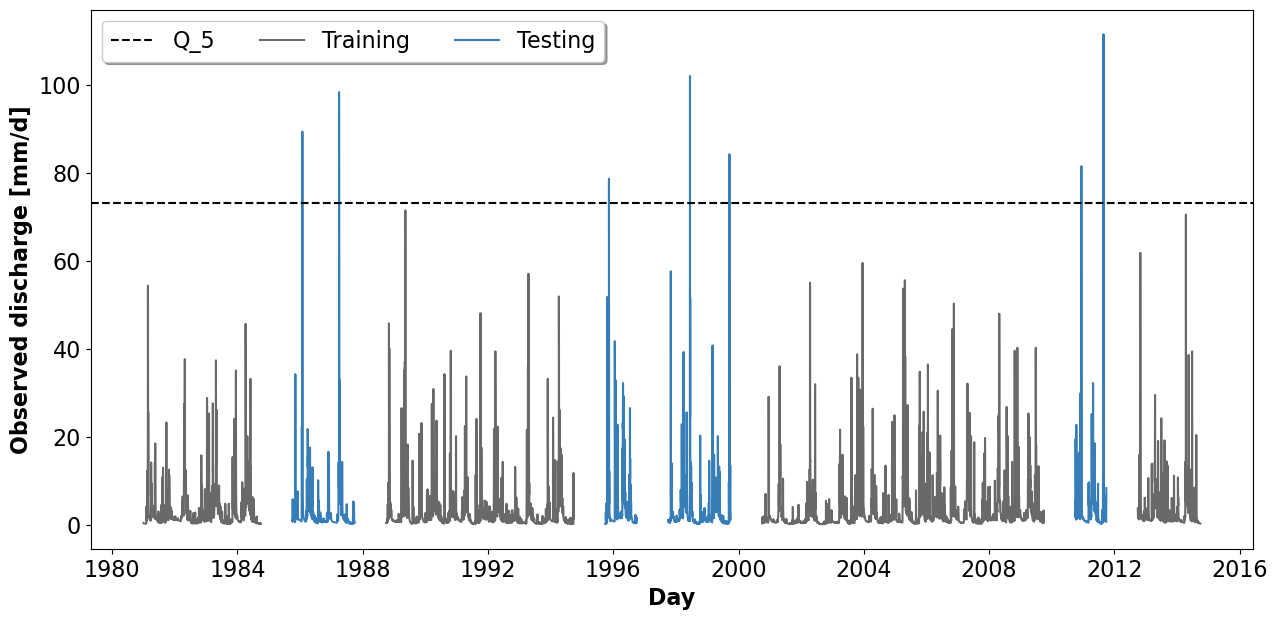

In [5]:
basin_to_analyze = "01054200"
plt.rcParams["figure.figsize"] = (15, 7)

# Training
for i, start_date in enumerate(dict_train[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_train[basin_to_analyze]["end_dates"][i])
    df_training = observed_values[basin_to_analyze]["y_obs"][
        observed_values[basin_to_analyze]["y_obs"].index.isin(date_range)
    ]
    plt.plot(df_training, color="dimgrey")

# Testing
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_testing = observed_values[basin_to_analyze]["y_obs"][
        observed_values[basin_to_analyze]["y_obs"].index.isin(date_range)
    ]
    plt.plot(df_testing, color=color_palette["observed"])

# 5 year return period line
discharge_statistics = pd.read_csv(path_discharge_statistics)
discharge_statistics["basin"] = discharge_statistics["basin"].str.replace("CAMELS_", "")
discharge_statistics.set_index("basin", inplace=True)
plt.axhline(y=discharge_statistics.loc[basin_to_analyze, "5"], color="black", linestyle="--", label="Q_5")

# draw temporary red and blue lines and use them to create a legend
plt.plot([], color="dimgrey", label="Training")
plt.plot([], color=color_palette["observed"], label="Testing")

# Format plot
plt.xlabel("Day", fontsize=16, fontweight="bold")
plt.ylabel("Observed discharge [mm/d]", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=16)
plt.legend(loc="upper left", fontsize=16, shadow=True, ncol=3)

Part 5. Peak analysis for observed data

In [6]:
peak_threshold = "1.01"
obs_peaks_per_basin = {}
for basin, df in hybrid_results.items():
    peaks_loc, _ = scipy.signal.find_peaks(df["y_obs"].values, distance=7, prominence=np.std(df["y_obs"].values))

    peaks = df.iloc[peaks_loc]["y_obs"]

    mask = peaks > discharge_statistics.loc[basin, peak_threshold]
    obs_peaks_per_basin[basin] = {"value": peaks.values[mask], "date": peaks.index[mask]}

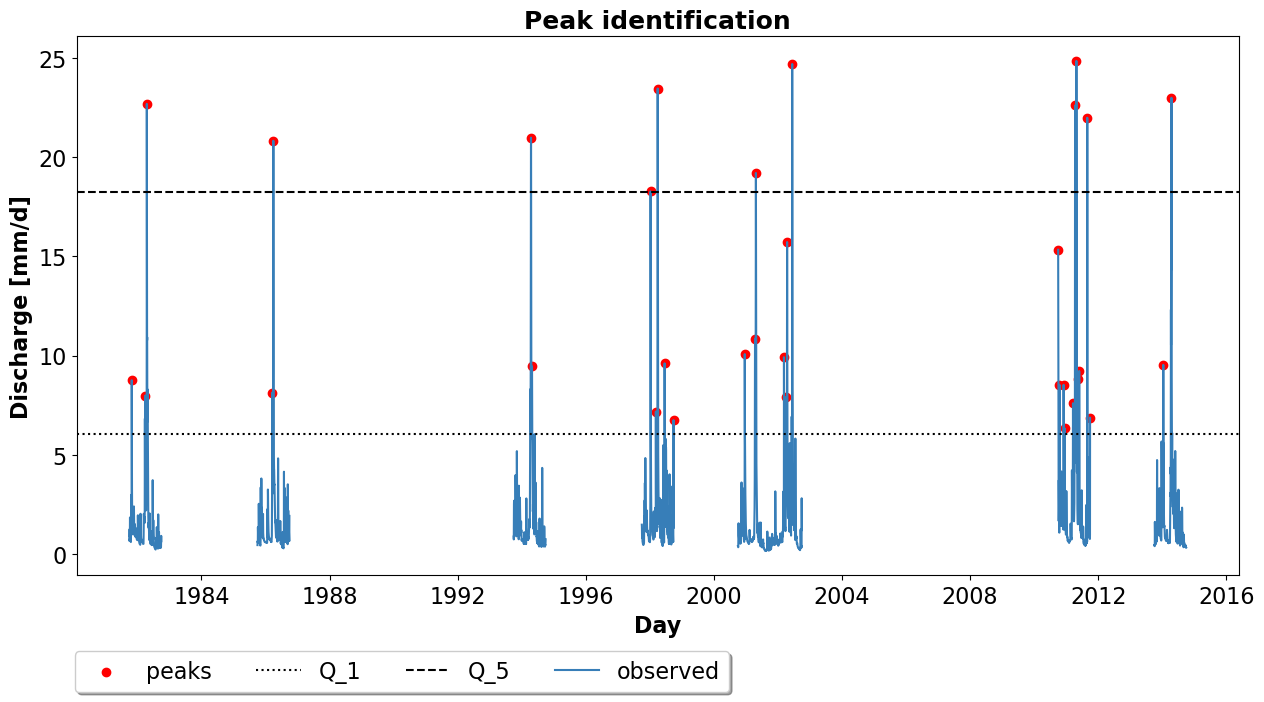

In [7]:
basin_to_analyze = "04296000"  #  04296000 01022500 01073000 08200000 01435000
plt.rcParams["figure.figsize"] = (15, 7)

# Observed
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_obs = hybrid_results[basin_to_analyze]["y_obs"][hybrid_results[basin_to_analyze].index.isin(date_range)]
    plt.plot(df_obs.index, df_obs, color=color_palette["observed"])

plt.scatter(
    obs_peaks_per_basin[basin_to_analyze]["date"],
    obs_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    label="peaks",
    color="r",
)

plt.axhline(y=discharge_statistics.loc[basin_to_analyze, "1.01"], color="black", linestyle="dotted", label="Q_1")
plt.axhline(y=discharge_statistics.loc[basin_to_analyze, "5"], color="black", linestyle="--", label="Q_5")

plt.plot([], color=color_palette["observed"], label="observed")

# Format plot
plt.xlabel("Day", fontsize=16, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=16, fontweight="bold")
plt.title("Peak identification", fontsize=18, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=16)
plt.legend(loc="upper center", bbox_to_anchor=(0.28, -0.12), fontsize=16, shadow=True, ncol=4)

Part 6. Peak identification for the different models

In [8]:
hybrid_peaks_per_basin = {}
# we use the id of the observed peaks plus a +-2 day window to identify the associated peak in the simulation
tolerance = 2

# Hybrid model -------------------------------------------------------------------------------------------------------
for basin, peak_info in obs_peaks_per_basin.items():
    max_value = []
    max_value_dates = []
    for date in peak_info["date"]:
        window_df = hybrid_results[basin]["y_sim"].loc[
            date - pd.Timedelta(days=tolerance) : date + pd.Timedelta(days=tolerance)
        ]
        max_value_dates.append(window_df.idxmax())
        max_value.append(window_df.loc[window_df.idxmax()])

    hybrid_peaks_per_basin[basin] = {"value": max_value, "date": max_value_dates}

# LSTM model -------------------------------------------------------------------------------------------------------
lstm_peaks_per_basin = {}
for basin, peak_info in obs_peaks_per_basin.items():
    max_value = []
    max_value_dates = []
    for date in peak_info["date"]:
        window_df = lstm_results[basin]["y_sim"].loc[
            date - pd.Timedelta(days=tolerance) : date + pd.Timedelta(days=tolerance)
        ]
        max_value_dates.append(window_df.idxmax())
        max_value.append(window_df.loc[window_df.idxmax()])

    lstm_peaks_per_basin[basin] = {"value": max_value, "date": max_value_dates}

# HBV model -------------------------------------------------------------------------------------------------------
hbv_peaks_per_basin = {}
for basin, peak_info in obs_peaks_per_basin.items():
    max_value = []
    max_value_dates = []
    for date in peak_info["date"]:
        window_df = hbv_results[basin]["y_sim"].loc[
            date - pd.Timedelta(days=tolerance) : date + pd.Timedelta(days=tolerance)
        ]
        max_value_dates.append(window_df.idxmax())
        max_value.append(window_df.loc[window_df.idxmax()])

    hbv_peaks_per_basin[basin] = {"value": max_value, "date": max_value_dates}

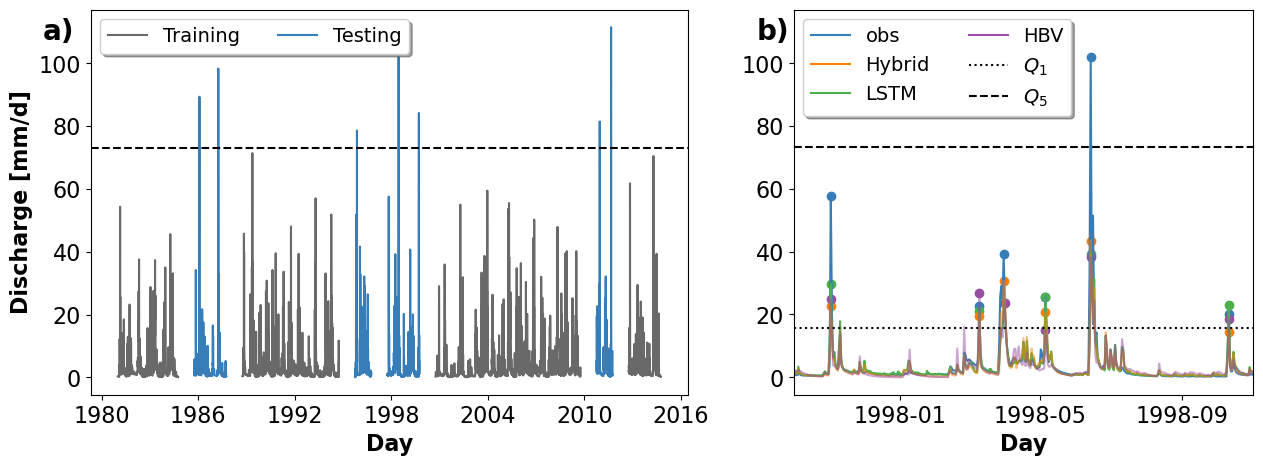

In [9]:
basin_to_analyze = "01054200"
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"width_ratios": [1.3, 1]})

# Training
for i, start_date in enumerate(dict_train[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_train[basin_to_analyze]["end_dates"][i])
    df_training = observed_values[basin_to_analyze]["y_obs"][
        observed_values[basin_to_analyze]["y_obs"].index.isin(date_range)
    ]
    axs[0].plot(df_training, color="dimgrey")  # "#4daf4a"

# Testing
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_testing = observed_values[basin_to_analyze]["y_obs"][
        observed_values[basin_to_analyze]["y_obs"].index.isin(date_range)
    ]
    axs[0].plot(df_testing, color=color_palette["observed"])

# 5 year return period line
discharge_statistics = pd.read_csv(path_discharge_statistics)
discharge_statistics["basin"] = discharge_statistics["basin"].str.replace("CAMELS_", "")
discharge_statistics.set_index("basin", inplace=True)
axs[0].axhline(y=discharge_statistics.loc[basin_to_analyze, "5"], color="black", linestyle="--")

# draw temporary lines and use them to create a legend
axs[0].plot([], color="dimgrey", label="Training")
axs[0].plot([], c=color_palette["observed"], label="Testing")

# Format plot
axs[0].text(-0.08, 0.98, "a)", transform=axs[0].transAxes, fontsize=20, fontweight="bold", verticalalignment="top")
axs[0].set_xlabel("Day", fontsize=16, fontweight="bold")
axs[0].set_ylabel("Discharge [mm/d]", fontsize=16, fontweight="bold")
axs[0].xaxis.set_major_locator(mdates.YearLocator(6))  # Change interval to 6 months
axs[0].tick_params(axis="both", which="major", labelsize=16)
axs[0].legend(loc="upper left", fontsize=14, shadow=True, ncol=2)


# Observed data ------------------------------------------------------------------------------------------------------
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_obs = hybrid_results[basin_to_analyze]["y_obs"][hybrid_results[basin_to_analyze].index.isin(date_range)]
    axs[1].plot(df_obs.index, df_obs, color=color_palette["observed"])
axs[1].scatter(
    obs_peaks_per_basin[basin_to_analyze]["date"],
    obs_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    color=color_palette["observed"],
)

# LSTM ------------------------------------------------------------------------------------------------------
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_lstm = lstm_results[basin_to_analyze]["y_sim"][lstm_results[basin_to_analyze].index.isin(date_range)]
    axs[1].plot(df_lstm.index, df_lstm, color=color_palette["LSTM"])
axs[1].scatter(
    lstm_peaks_per_basin[basin_to_analyze]["date"],
    lstm_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    color=color_palette["LSTM"],
)

# Hybrid ------------------------------------------------------------------------------------------------------
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_hyb = hybrid_results[basin_to_analyze]["y_sim"][hybrid_results[basin_to_analyze].index.isin(date_range)]
    axs[1].plot(df_hyb.index, df_hyb, alpha=0.5, color=color_palette["Hybrid"])
axs[1].scatter(
    hybrid_peaks_per_basin[basin_to_analyze]["date"],
    hybrid_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    color=color_palette["Hybrid"],
)

# HBV ------------------------------------------------------------------------------------------------------
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_hyb = hbv_results[basin_to_analyze]["y_sim"][hbv_results[basin_to_analyze].index.isin(date_range)]
    axs[1].plot(df_hyb.index, df_hyb, alpha=0.5, color=color_palette["HBV"])
axs[1].scatter(
    hbv_peaks_per_basin[basin_to_analyze]["date"],
    hbv_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    color=color_palette["HBV"],
)

# Add return period limit
axs[1].axhline(y=discharge_statistics.loc[basin_to_analyze, "1.01"], color="black", linestyle="dotted")
axs[1].axhline(y=discharge_statistics.loc[basin_to_analyze, "5"], color="black", linestyle="--")

# Dummy plots for legend
axs[1].plot([], color=color_palette["observed"], label="obs")
axs[1].plot([], color=color_palette["Hybrid"], label="Hybrid")
axs[1].plot([], color=color_palette["LSTM"], label="LSTM")
axs[1].plot([], color=color_palette["HBV"], label="HBV")
axs[1].plot([], color="black", linestyle="dotted", label=r"$Q_1$")
axs[1].plot([], color="black", linestyle="--", label=r"$Q_5$")

# Format plot
axs[1].text(-0.08, 0.98, "b)", transform=axs[1].transAxes, fontsize=20, fontweight="bold", verticalalignment="top")
axs[1].tick_params(axis="both", which="major", labelsize=16)
axs[1].set_xlim(datetime.datetime(1997, 10, 1), datetime.datetime(1998, 11, 1))
axs[1].set_xlabel("Day", fontsize=16, fontweight="bold")
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Change interval to 4 months
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axs[1].legend(fontsize=14, ncol=2, loc="upper left", shadow=True)
#plt.savefig("fig01.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

Part 7. Overall model comparison

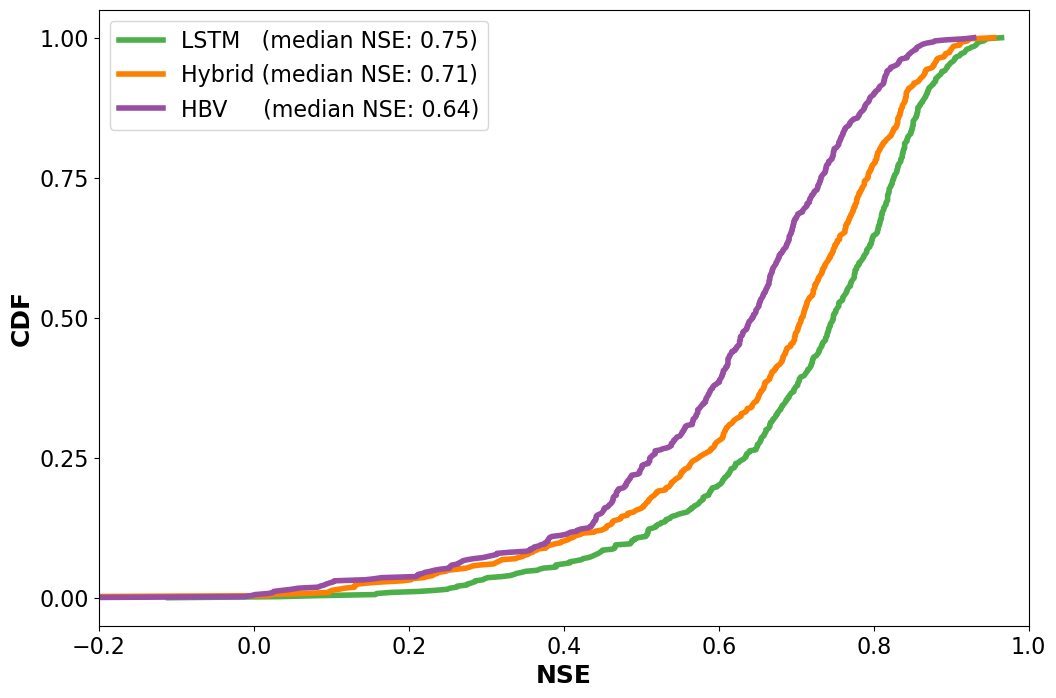

In [10]:
df_NSE_lstm = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "NSE_LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

df_NSE_hybrid = pd.DataFrame(
    data={
        "basin_id": list(hybrid_results.keys()),
        "NSE_Hybrid": np.round(nse(df_results=hybrid_results, average=False), 3),
    }
).set_index("basin_id")

df_NSE_hbv = pd.DataFrame(
    data={"basin_id": list(hbv_results.keys()), "NSE_HBV": np.round(nse(df_results=hbv_results, average=False), 3)}
).set_index("basin_id")

df_NSE_comparison = pd.concat([df_NSE_hybrid, df_NSE_lstm, df_NSE_hbv], axis=1)
df_NSE_comparison = df_NSE_comparison.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison["cdf"] = np.arange(len(df_NSE_comparison)) / (len(df_NSE_comparison) - 1)

# Create plot
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(
    df_NSE_comparison["NSE_LSTM"],
    df_NSE_comparison["cdf"],
    label=f"LSTM   (median NSE: {df_NSE_comparison["NSE_LSTM"].median():.2f})",
    linewidth=4,
    color=color_palette["LSTM"],
)
plt.plot(
    df_NSE_comparison["NSE_Hybrid"],
    df_NSE_comparison["cdf"],
    label=f"Hybrid (median NSE: {df_NSE_comparison["NSE_Hybrid"].median():.2f})",
    linewidth=4,
    color=color_palette["Hybrid"],
)

plt.plot(
    df_NSE_comparison["NSE_HBV"],
    df_NSE_comparison["cdf"],
    label=f"HBV     (median NSE: {df_NSE_comparison["NSE_HBV"].median():.2f})",
    linewidth=4,
    color=color_palette["HBV"],
)


plt.xlim(-0.2, 1)
plt.xlabel("NSE", fontsize=18, fontweight="bold")
plt.ylabel("CDF", fontsize=18, fontweight="bold")
plt.xticks(fontsize=16)
plt.yticks([i * 0.25 for i in range(5)], fontsize=16)

plt.legend(loc="upper left", fontsize=16)
# plt.savefig("fig02.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

Part 8. Peak analysis: Absolute percentage error

In [11]:
perc_error_peaks = {}
for basin, peak_info in obs_peaks_per_basin.items():
    obs_peaks = peak_info["value"]
    lstm_peaks = np.array(lstm_peaks_per_basin[basin]["value"])
    hybrid_peaks = np.array(hybrid_peaks_per_basin[basin]["value"])
    hbv_peaks = np.array(hbv_peaks_per_basin[basin]["value"])

    perc_error_peaks[basin] = {
        "LSTM": np.abs(obs_peaks - lstm_peaks) / obs_peaks,
        "Hybrid": np.abs(obs_peaks - hybrid_peaks) / obs_peaks,
        "HBV": np.abs(obs_peaks - hbv_peaks) / obs_peaks,
    }

# Concatenate all the errors, of each model, in a list
perc_error_peaks_lstm = []
perc_error_peaks_hybrid = []
perc_error_peaks_hbv = []
for peak_error in perc_error_peaks.values():
    perc_error_peaks_lstm.extend(peak_error["LSTM"])
    perc_error_peaks_hybrid.extend(peak_error["Hybrid"])
    perc_error_peaks_hbv.extend(peak_error["HBV"])

Part 9. Peak analysis: Absolute percentage error - by return period

In [12]:
# Classified observed peaks based on their return period
classified_peaks = {}
for basin, peak_info in obs_peaks_per_basin.items():
    peaks = peak_info["value"]

    # Return periods per basin
    TR_1 = discharge_statistics.loc[basin, "1.01"]
    TR_5 = discharge_statistics.loc[basin, "5"]
    TR_25 = discharge_statistics.loc[basin, "25"]
    TR_50 = discharge_statistics.loc[basin, "50"]
    TR_100 = discharge_statistics.loc[basin, "100"]

    # Classify the values of the "peaks" vector
    classification = np.zeros_like(peaks)
    classification[(peaks >= TR_1) & (peaks < TR_5)] = 1
    classification[(peaks >= TR_5) & (peaks < TR_25)] = 2
    classification[(peaks >= TR_25) & (peaks < TR_50)] = 3
    classification[(peaks >= TR_50) & (peaks < TR_100)] = 4
    classification[peaks >= TR_100] = 5

    classified_peaks[basin] = classification


model_name = ["LSTM", "Hybrid", "HBV"]
TR_range = ["1-5", "5-25", "25-50", "50-100", "100+"]

# Intialize structure to save error per model and per return period
error_per_model = {model: {TR: [] for TR in TR_range} for model in model_name}
# Process and store the error per model per return period
for basin, peak_error_per_model in perc_error_peaks.items():
    for model in peak_error_per_model.keys():
        for i, TR in enumerate(TR_range):
            error_per_model[model][TR].extend(peak_error_per_model[model][classified_peaks[basin] == i + 1])

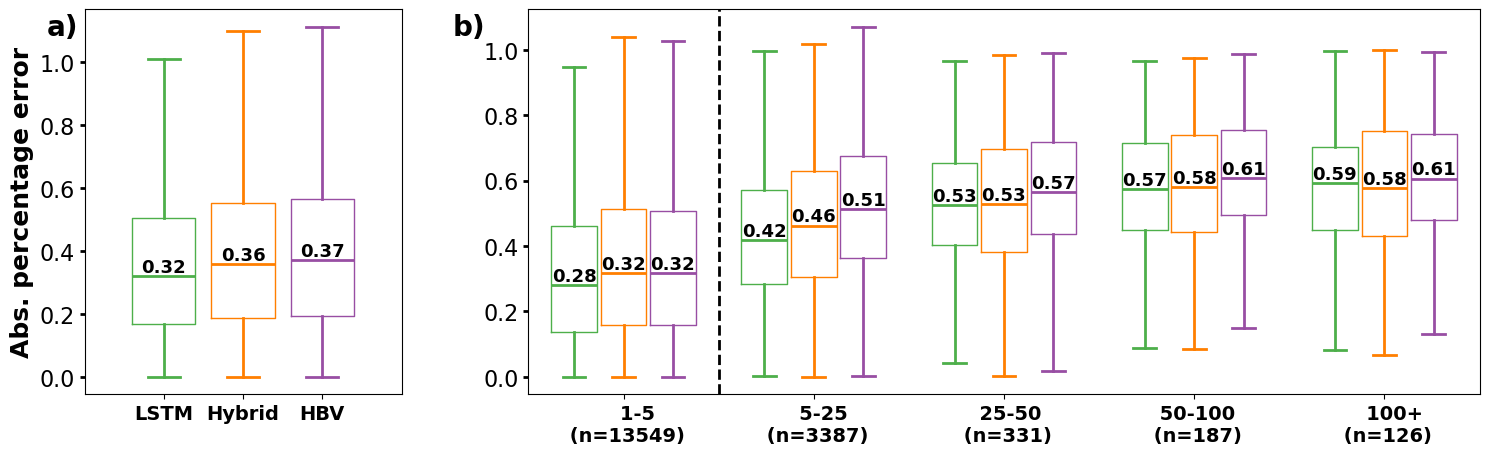

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={"width_ratios": [1, 3]})

# Boxplots for absolute percentage errors
axs[0].boxplot(
    perc_error_peaks_lstm,
    positions=[0.4],
    showfliers=False,
    widths=0.08,
    patch_artist=False,
    boxprops=dict(color=color_palette["LSTM"]),
    medianprops=dict(color=color_palette["LSTM"], linewidth=2),
    whiskerprops=dict(color=color_palette["LSTM"], linewidth=2),
    capprops=dict(color=color_palette["LSTM"], linewidth=2),
)
axs[0].boxplot(
    perc_error_peaks_hybrid,
    positions=[0.5],
    showfliers=False,
    widths=0.08,
    patch_artist=False,
    boxprops=dict(color=color_palette["Hybrid"]),
    medianprops=dict(color=color_palette["Hybrid"], linewidth=2),
    whiskerprops=dict(color=color_palette["Hybrid"], linewidth=2),
    capprops=dict(color=color_palette["Hybrid"], linewidth=2),
)
axs[0].boxplot(
    perc_error_peaks_hbv,
    positions=[0.6],
    showfliers=False,
    widths=0.08,
    patch_artist=False,
    boxprops=dict(color=color_palette["HBV"]),
    medianprops=dict(color=color_palette["HBV"], linewidth=2),
    whiskerprops=dict(color=color_palette["HBV"], linewidth=2),
    capprops=dict(color=color_palette["HBV"], linewidth=2),
)


axs[0].text(-0.12, 0.99, "a)", transform=axs[0].transAxes, fontsize=20, fontweight="bold", verticalalignment="top")
axs[0].set_xlim(left=0.3, right=0.7)
axs[0].set_xticks([0.4, 0.5, 0.6])
axs[0].set_xticklabels(["LSTM", "Hybrid", "HBV"], fontsize=14, fontweight="bold")
axs[0].set_ylabel("Abs. percentage error", fontsize=18, fontweight="bold")
axs[0].tick_params(axis="y", which="major", labelsize=16, width=2)
axs[0].text(
    0.4,
    np.median(perc_error_peaks_lstm),
    f"{np.median(perc_error_peaks_lstm):.2f}",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=13,
    fontweight="bold",
    color="black",
)
axs[0].text(
    0.5,
    np.median(perc_error_peaks_hybrid),
    f"{np.median(perc_error_peaks_hybrid):.2f}",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=13,
    fontweight="bold",
    color="black",
)
axs[0].text(
    0.6,
    np.median(perc_error_peaks_hbv),
    f"{np.median(perc_error_peaks_hbv):.2f}",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=13,
    fontweight="bold",
    color="black",
)


step = 0.5
bin_names = [f"{TR_range[i]:>7}\n (n={len(value)})" for i, (_, value) in enumerate(error_per_model["Hybrid"].items())]
x = np.arange(0, len(list(bin_names)) * step, step)  # the label locations
width = 0.13  # Width of each boxplot

# Iterate through each bin_name and create boxplots for each model
for i, TR in enumerate(TR_range):
    # LSTM boxplots
    errors_lstm = error_per_model["LSTM"][TR]
    axs[1].boxplot(
        errors_lstm,
        positions=[x[i] - width],
        showfliers=False,
        widths=0.12,
        patch_artist=False,
        boxprops=dict(color=color_palette["LSTM"]),
        medianprops=dict(color=color_palette["LSTM"], linewidth=2),
        whiskerprops=dict(color=color_palette["LSTM"], linewidth=2),
        capprops=dict(color=color_palette["LSTM"], linewidth=2),
    )

    axs[1].text(
        x[i] - width,
        np.median(errors_lstm),
        f"{np.median(errors_lstm):.2f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=13,
        fontweight="bold",
        color="black",
    )

    # Hybrid boxplots
    errors_hybrid = error_per_model["Hybrid"][TR]
    axs[1].boxplot(
        errors_hybrid,
        positions=[x[i]],
        showfliers=False,
        widths=0.12,
        patch_artist=False,
        boxprops=dict(color=color_palette["Hybrid"]),
        medianprops=dict(color=color_palette["Hybrid"], linewidth=2),
        whiskerprops=dict(color=color_palette["Hybrid"], linewidth=2),
        capprops=dict(color=color_palette["Hybrid"], linewidth=2),
    )

    axs[1].text(
        x[i],
        np.median(errors_hybrid),
        f"{np.median(errors_hybrid):.2f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=13,
        fontweight="bold",
        color="black",
    )

    # HBV boxplots
    errors_hbv = error_per_model["HBV"][TR]
    axs[1].boxplot(
        errors_hbv,
        positions=[x[i] + width],
        showfliers=False,
        widths=0.12,
        patch_artist=False,
        boxprops=dict(color=color_palette["HBV"]),
        medianprops=dict(color=color_palette["HBV"], linewidth=2),
        whiskerprops=dict(color=color_palette["HBV"], linewidth=2),
        capprops=dict(color=color_palette["HBV"], linewidth=2),
    )

    axs[1].text(
        x[i] + width,
        np.median(errors_hbv),
        f"{np.median(errors_hbv):.2f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=13,
        fontweight="bold",
        color="black",
    )

# Line dividing interpolation - extrapolation errors
axs[1].text(-0.08, 0.99, "b)", transform=axs[1].transAxes, fontsize=20, fontweight="bold", verticalalignment="top")
axs[1].axvline(x=0.25, color="black", linestyle="--", linewidth=2)

# Dummy plots for the legend
axs[1].plot([], c=color_palette["LSTM"], label="LSTM")
axs[1].plot([], c=color_palette["Hybrid"], label="Hybrid")
axs[1].plot([], c=color_palette["HBV"], label="HBV")

# Add labels, titles, legends, etc. as needed
axs[1].set_xticks(x, bin_names, fontsize=14, fontweight="bold")
axs[1].set_xlim(left=x[0] - step / 2, right=x[-1] + step / 2)
axs[1].tick_params(axis="y", which="major", labelsize=16, width=2)
# plt.savefig("fig03.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

Part 10. Spatial visualization of model performance

In [14]:
# Similar to error_per_model. We store for each model, and for each return period, the errors. However, here we
# differentiate the error between the different basins.
error_per_model_v2 = {model: {TR: [] for TR in TR_range} for model in model_name}

for model, TRS in error_per_model_v2.items():
    for i, TR in enumerate(TRS.keys()):
        median_error_per_basin = {}
        for basin, peak_error_per_model in perc_error_peaks.items():
            errors = peak_error_per_model[model][classified_peaks[basin] == i + 1]
            median_error_per_basin[basin] = (
                np.median(errors) if errors.size > 1 else (errors[0] if errors.size == 1 else None)
            )

        df_basin_error = pd.DataFrame.from_dict(median_error_per_basin, orient="index", columns=["Abs_perc_error"])
        df_basin_error.index.name = "gauge_id"
        error_per_model_v2[model][TR] = df_basin_error

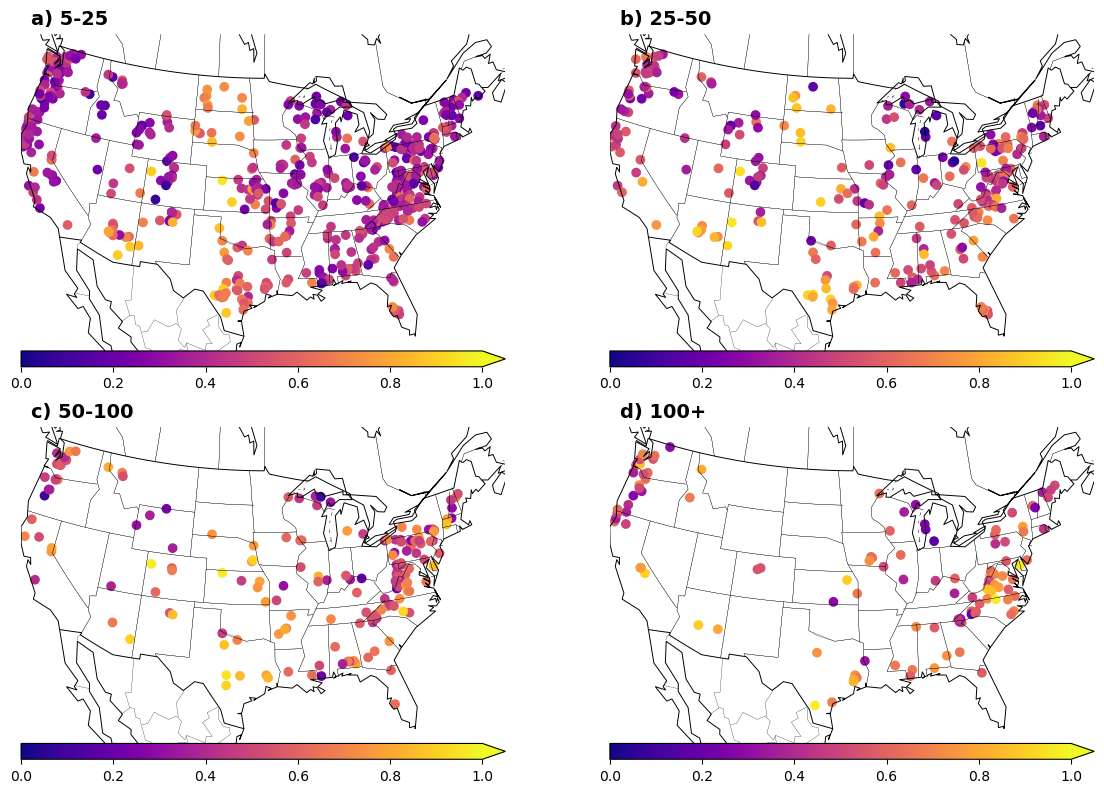

In [15]:
model = "LSTM"  # change to LSTM Hybrid or HBV
TR = ["5-25", "25-50", "50-100", "100+"]
labels = ["a)", "b)", "c)", "d)"]

# load dataframe with lat/lon information
df_attributes = load_camels_us_attributes(path_data, list(perc_error_peaks.keys())).loc[:, ["gauge_lon", "gauge_lat"]]

fig = plt.figure(figsize=(12, 8))

for i, TR_interval in enumerate(TR):
    df_error = error_per_model_v2[model][TR_interval]
    plot_data = df_error.join(df_attributes).dropna(subset=["Abs_perc_error"])

    ax = fig.add_subplot(2, 2, i + 1)
    m = Basemap(
        llcrnrlon=-118, llcrnrlat=22, urcrnrlon=-62, urcrnrlat=49, projection="lcc", lat_1=33, lat_2=45, lon_0=-95
    )
    m.drawcoastlines(linewidth=0.7)
    m.drawcountries(linewidth=0.7)
    m.drawstates(linewidth=0.2)

    x, y = m(plot_data["gauge_lon"].values, plot_data["gauge_lat"].values)  # transform coordinates
    scatter = m.scatter(x, y, c=plot_data["Abs_perc_error"].values, vmin=0, vmax=1, cmap="plasma")
    ax.axis(False)
    m.colorbar(scatter, ax=ax, pad=0, shrink=0.8, location="bottom", extend="max")

    ax.text(
        0.02,
        1.08,
        f"{labels[i]} {TR_interval}",
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        ha="left",
        va="top",
    )

plt.tight_layout()

C:\Users\acuna\AppData\Local\Temp\ipykernel_20240\786007541.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


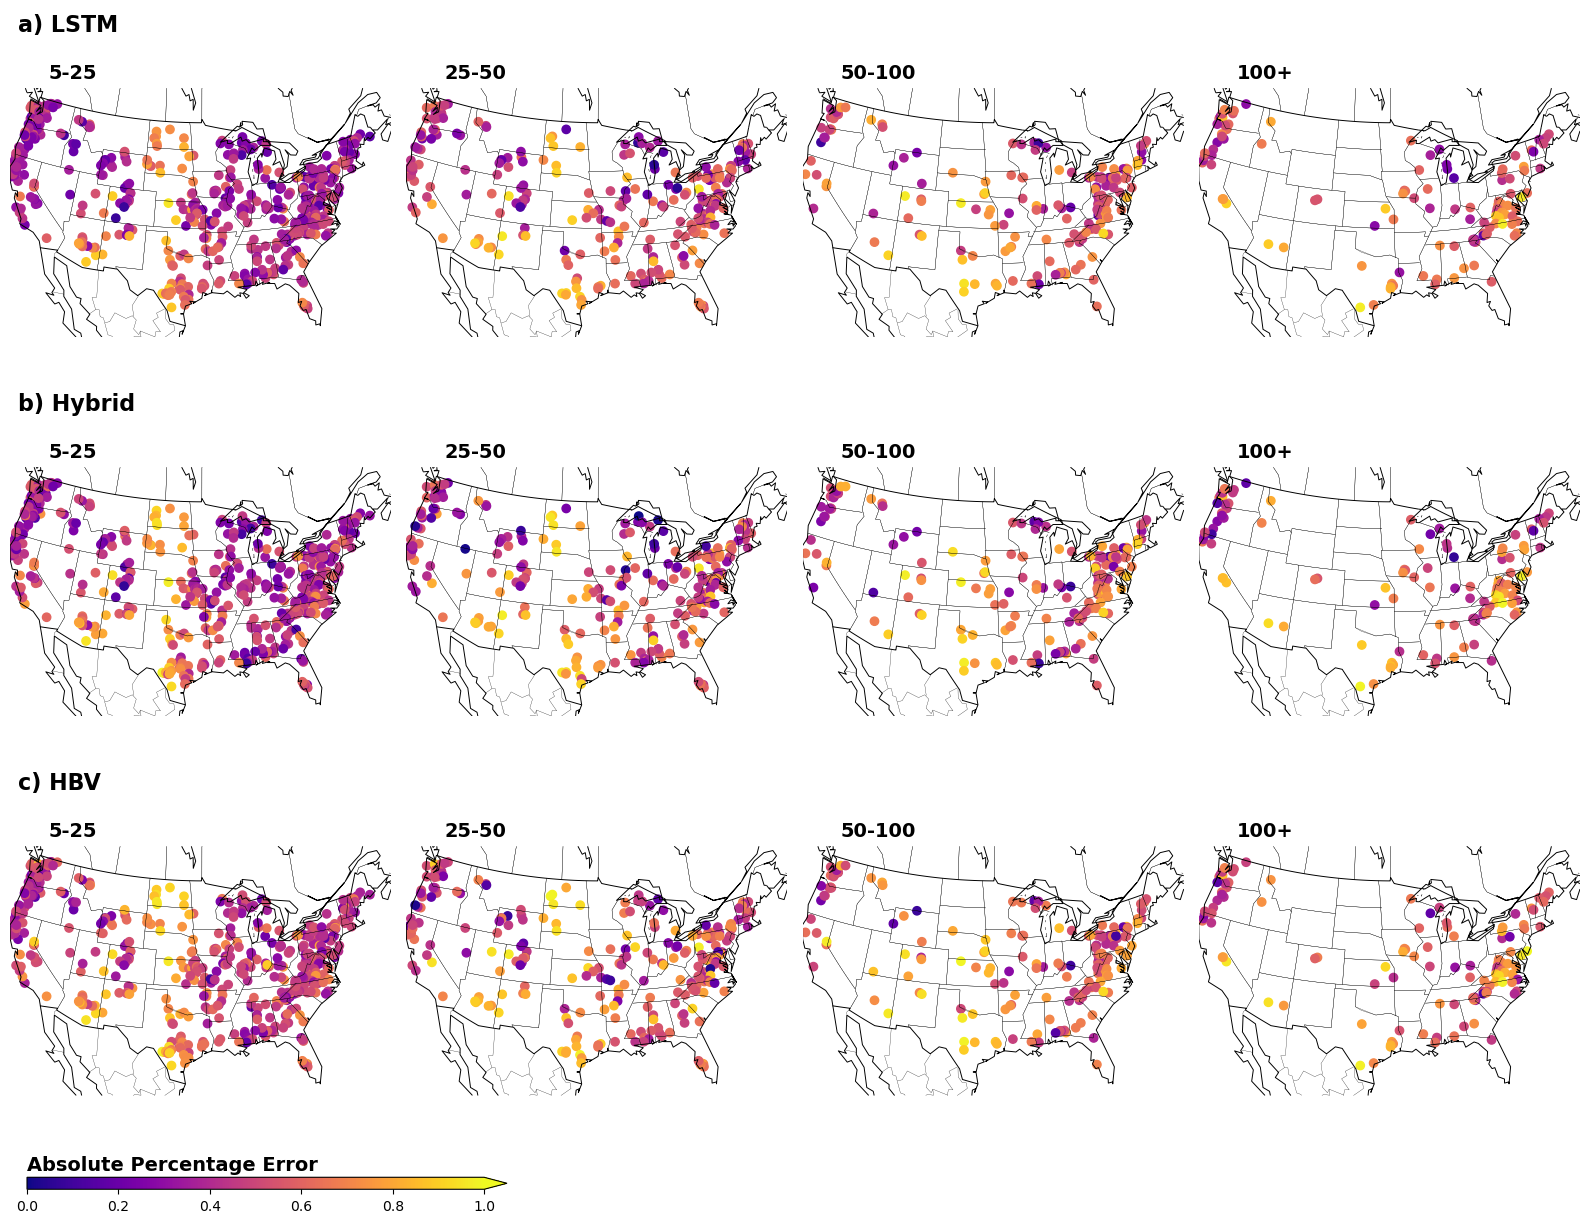

In [16]:
# Figure with all the models at the same time
models = ["LSTM", "Hybrid", "HBV"]
labels = ["a", "b", "c"]
TR = ["5-25", "25-50", "50-100", "100+"]

# Load dataframe with lat/lon information
df_attributes = load_camels_us_attributes(path_data, list(perc_error_peaks.keys())).loc[:, ["gauge_lon", "gauge_lat"]]

# Create the main figure
fig = plt.figure(figsize=(16, 12))

# Define color normalization and colormap for scatter plots and the color bar
vmin, vmax = 0, 1
cmap = "plasma"
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# Iterate over models
for i, model in enumerate(models):
    # Create a title for each row of the current model
    main_title = fig.add_subplot(len(models), 1, i + 1)
    main_title.axis("off")  # Hide the empty main axis created for the title

    # Iterate over the return periods
    for j, TR_interval in enumerate(TR):
        # Create individual subplots within the figure for each TR interval
        ax = fig.add_subplot(len(models), len(TR), i * len(TR) + j + 1)

        # Prepare data for current model and TR interval
        df_error = error_per_model_v2[model][TR_interval]
        plot_data = df_error.join(df_attributes).dropna(subset=["Abs_perc_error"])

        # Basemap configuration
        m = Basemap(
            llcrnrlon=-118,
            llcrnrlat=22,
            urcrnrlon=-62,
            urcrnrlat=49,
            projection="lcc",
            lat_1=33,
            lat_2=45,
            lon_0=-95,
            ax=ax,
        )
        m.drawcoastlines(linewidth=0.7)
        m.drawcountries(linewidth=0.7)
        m.drawstates(linewidth=0.2)

        # Transform coordinates and scatter plot
        x, y = m(plot_data["gauge_lon"].values, plot_data["gauge_lat"].values)
        scatter = m.scatter(x, y, c=plot_data["Abs_perc_error"].values, vmin=vmin, vmax=vmax, cmap=cmap)

        # Add main title for the model on the left side
        if j == 0:
            ax.text(
                0.02,
                1.3,
                f"{labels[i]}) {models[i]}",
                transform=ax.transAxes,
                fontsize=16,
                fontweight="bold",
                ha="left",
                va="top",
            )

        # Label each subplot within the 2x2 grid
        ax.text(0.1, 1.1, f"{TR_interval}", transform=ax.transAxes, fontsize=14, fontweight="bold", ha="left", va="top")

        # Hide axes for a cleaner look
        ax.axis("off")

# Add a single color bar below all plots with a specific offset
cbar_ax = fig.add_axes([0.02, 0, 0.3, 0.01])  # Position: [left, bottom, width, height]
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation="horizontal", extend="max")
cbar_ax.text(
    0,
    2.8,
    "Absolute Percentage Error",
    transform=cbar_ax.transAxes,
    fontsize=14,
    fontweight="bold",
    ha="left",
    va="top",
)

# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("figC1.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

Part 11. Spatial visualization of differences between model performance

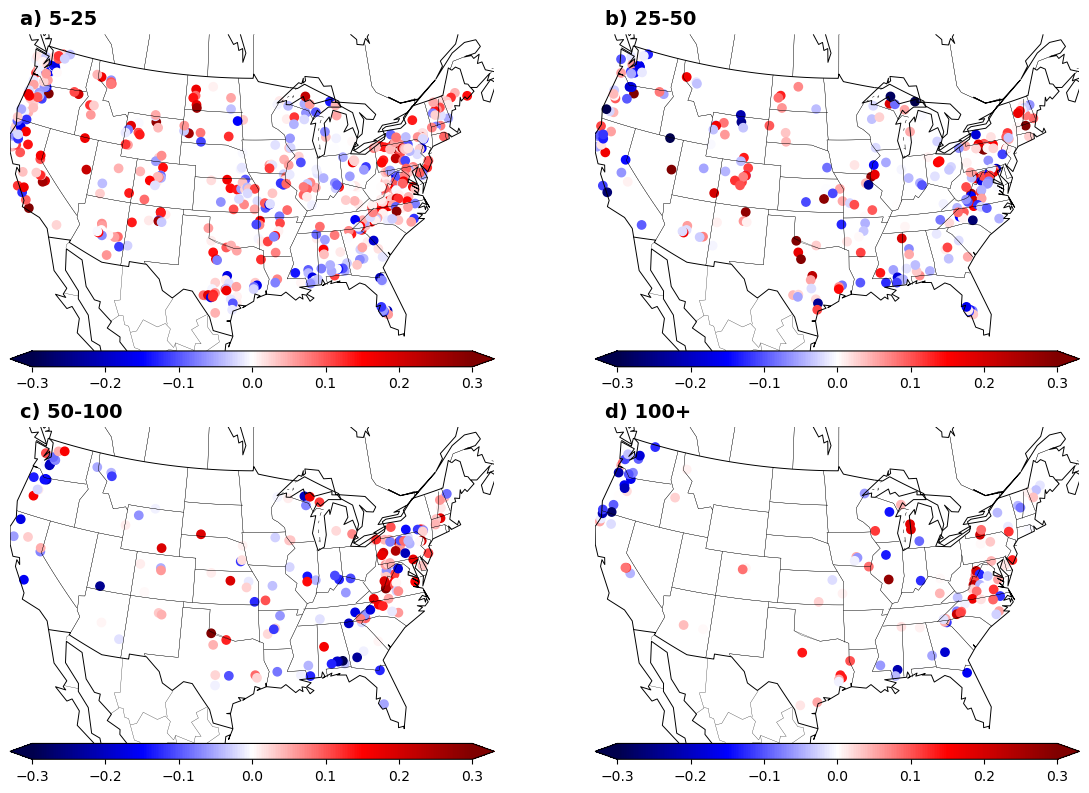

In [17]:
TR = ["5-25", "25-50", "50-100", "100+"]
labels = ["a)", "b)", "c)", "d)"]
model_dif = ["Hybrid", "LSTM"]

# load dataframe with lat/lon information
df_attributes = load_camels_us_attributes(path_data, list(perc_error_peaks.keys())).loc[:, ["gauge_lon", "gauge_lat"]]

fig = plt.figure(figsize=(12, 8))

for i, TR_interval in enumerate(TR):
    df_error = error_per_model_v2[model_dif[0]][TR_interval] - error_per_model_v2[model_dif[1]][TR_interval]
    plot_data = df_error.join(df_attributes).dropna(subset=["Abs_perc_error"])

    ax = fig.add_subplot(2, 2, i + 1)
    m = Basemap(
        llcrnrlon=-118, llcrnrlat=22, urcrnrlon=-62, urcrnrlat=49, projection="lcc", lat_1=33, lat_2=45, lon_0=-95
    )
    m.drawcoastlines(linewidth=0.7)
    m.drawcountries(linewidth=0.7)
    m.drawstates(linewidth=0.2)

    x, y = m(plot_data["gauge_lon"].values, plot_data["gauge_lat"].values)  # transform coordinates
    scatter = m.scatter(x, y, c=plot_data["Abs_perc_error"].values, vmin=-0.3, vmax=0.3, cmap="seismic")
    ax.axis(False)
    m.colorbar(scatter, ax=ax, pad=0, shrink=0.8, location="bottom", extend="both")

    ax.text(
        0.02,
        1.08,
        f"{labels[i]} {TR_interval}",
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        ha="left",
        va="top",
    )

plt.tight_layout()
# plt.savefig("fig04.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

C:\Users\acuna\AppData\Local\Temp\ipykernel_20240\622509145.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


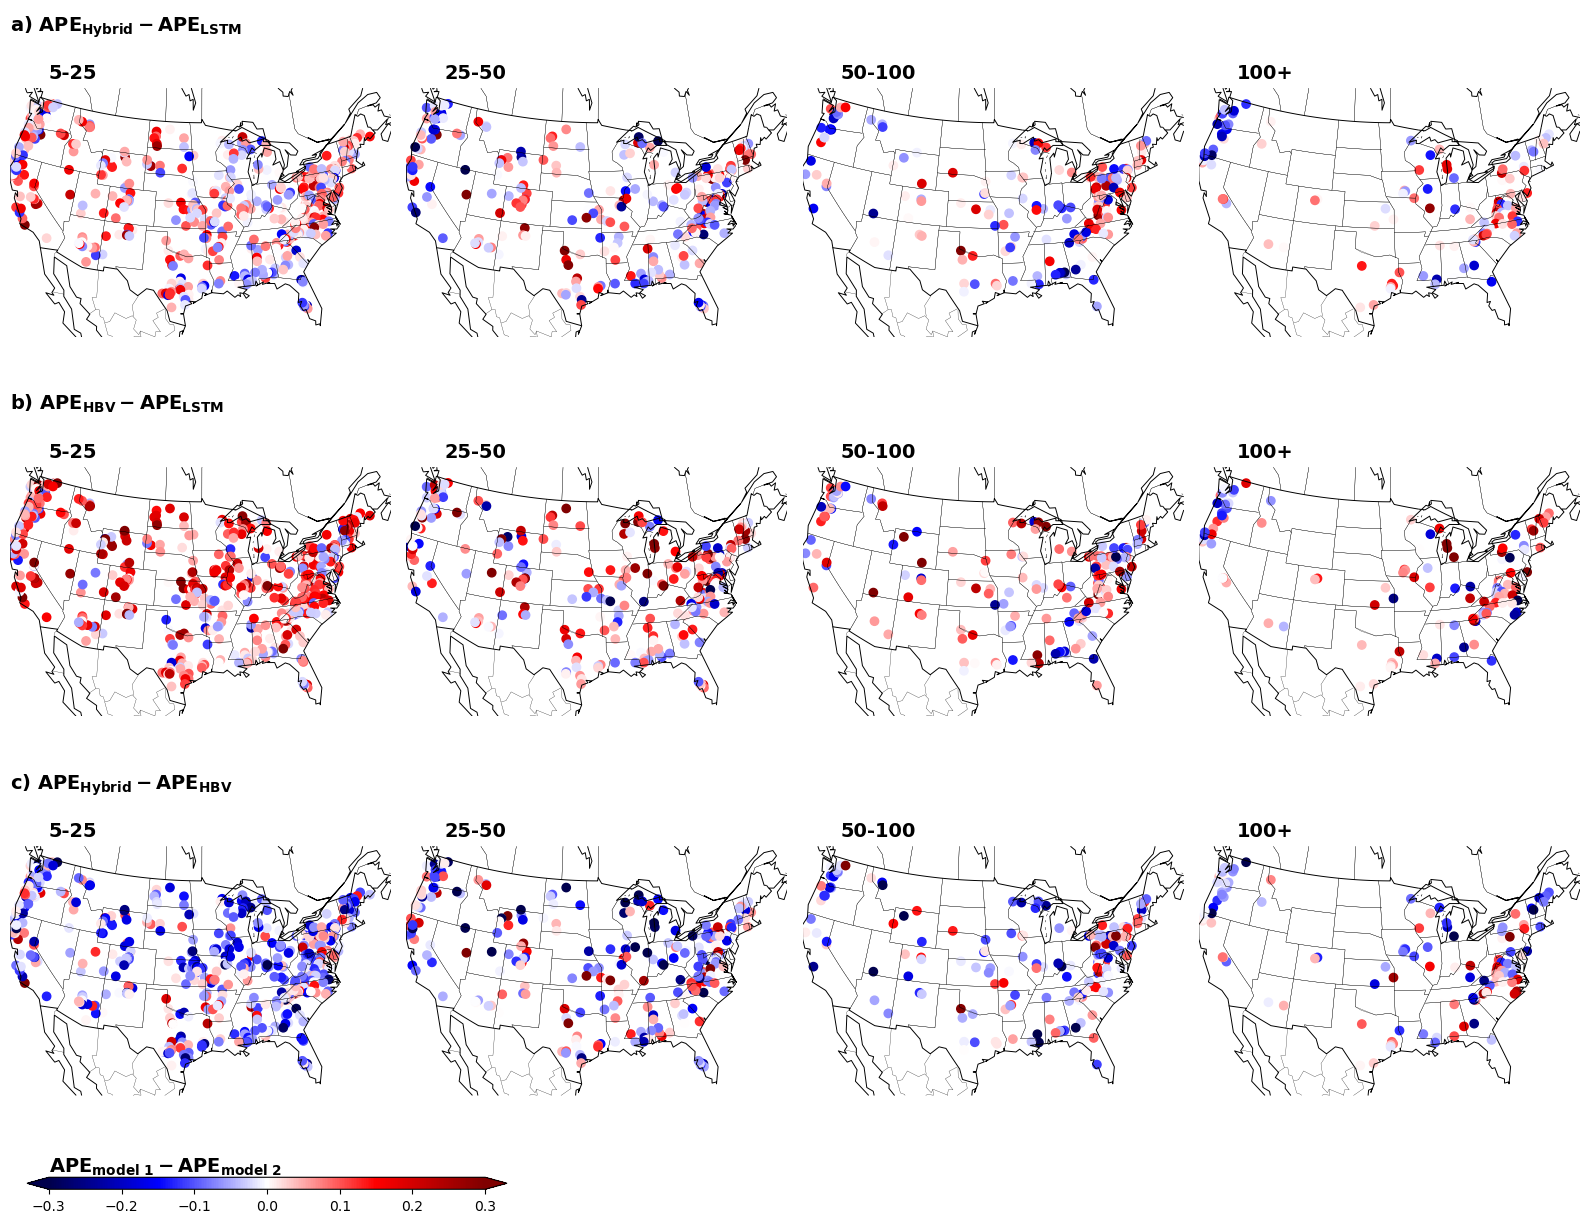

In [18]:
# Figure with all the models at the same time
labels = ["a", "b", "c"]
model_delta = [["Hybrid", "LSTM"], ["HBV", "LSTM"], ["Hybrid", "HBV"]]
labels = ["a", "b", "c"]
TR = ["5-25", "25-50", "50-100", "100+"]

# Load dataframe with lat/lon information
df_attributes = load_camels_us_attributes(path_data, list(perc_error_peaks.keys())).loc[:, ["gauge_lon", "gauge_lat"]]

# Create the main figure
fig = plt.figure(figsize=(16, 12))

# Define color normalization and colormap for scatter plots and the color bar
vmin, vmax = -0.3, 0.3
cmap = "seismic"
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# Iterate over models
for i, model in enumerate(model_delta):
    # Create a title for each row of the current model
    main_title = fig.add_subplot(len(models), 1, i + 1)
    main_title.axis("off")  # Hide the empty main axis created for the title

    # Iterate over the return periods
    for j, TR_interval in enumerate(TR):
        # Create individual subplots within the figure for each TR interval
        ax = fig.add_subplot(len(model_delta), len(TR), i * len(TR) + j + 1)

        # Prepare data for current model and TR interval
        df_error = error_per_model_v2[model[0]][TR_interval] - error_per_model_v2[model[1]][TR_interval]
        plot_data = df_error.join(df_attributes).dropna(subset=["Abs_perc_error"])

        # Basemap configuration
        m = Basemap(
            llcrnrlon=-118,
            llcrnrlat=22,
            urcrnrlon=-62,
            urcrnrlat=49,
            projection="lcc",
            lat_1=33,
            lat_2=45,
            lon_0=-95,
            ax=ax,
        )
        m.drawcoastlines(linewidth=0.7)
        m.drawcountries(linewidth=0.7)
        m.drawstates(linewidth=0.2)

        # Transform coordinates and scatter plot
        x, y = m(plot_data["gauge_lon"].values, plot_data["gauge_lat"].values)
        scatter = m.scatter(x, y, c=plot_data["Abs_perc_error"].values, vmin=vmin, vmax=vmax, cmap=cmap)

        # Add main title for the model on the left side
        if j == 0:
            ax.text(
                0,
                1.3,
                # f"{labels[i]}) {r"$\mathbf{\delta(Error_{"+model[0]+"} - Error_{"+model[1]+"})}$"}",
                f"{labels[i]}) {r"$\mathbf{APE_{"+model[0]+"} - APE_{"+model[1]+"}}$"}",
                transform=ax.transAxes,
                fontsize=14,
                fontweight="bold",
                ha="left",
                va="top",
            )

        # Label each subplot within the 2x2 grid
        ax.text(0.1, 1.1, f"{TR_interval}", transform=ax.transAxes, fontsize=14, fontweight="bold", ha="left", va="top")

        # Hide axes for a cleaner look
        ax.axis("off")

# Add a single color bar below all plots with a specific offset
cbar_ax = fig.add_axes([0.02, 0, 0.3, 0.01])  # Position: [left, bottom, width, height]
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation="horizontal", extend="both")
cbar_ax.text(
    0,
    2.8,
    # r"$\mathbf{\delta(Error_{model\ 1} - Error_{model\ 2})}$",
    r"$\mathbf{APE_{model\ 1} - APE_{model\ 2}}$",
    transform=cbar_ax.transAxes,
    fontsize=14,
    ha="left",
    va="top",
)

# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("figC2.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

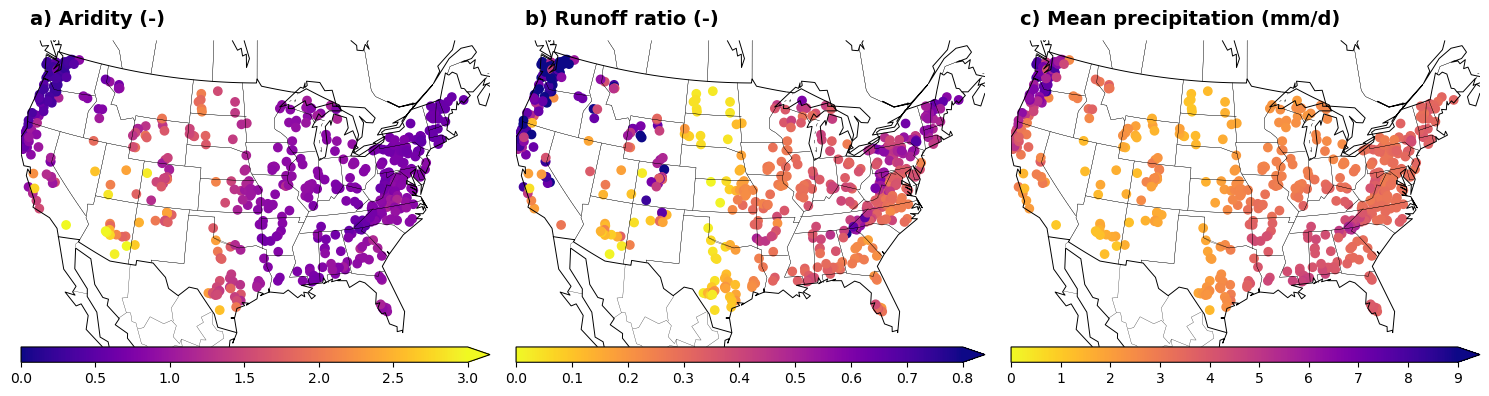

In [19]:
TR = ["5-25", "25-50", "50-100", "100+"]
attributes = ["aridity", "runoff_ratio", "p_mean"]
labels = ["a) Aridity (-)", "b) Runoff ratio (-)", "c) Mean precipitation (mm/d)"]
color_map = ["plasma", "plasma_r", "plasma_r"]
limits = [[0, 3], [0, 0.8], [0, 9]]

# load dataframe with lat/lon information
df_attributes = load_camels_us_attributes(path_data, list(perc_error_peaks.keys())).loc[
    :, ["gauge_lon", "gauge_lat"] + attributes
]

fig = plt.figure(figsize=(15, 5))

for i, attribute in enumerate(attributes):
    ax = fig.add_subplot(1, len(attributes), i + 1)
    m = Basemap(
        llcrnrlon=-118, llcrnrlat=22, urcrnrlon=-62, urcrnrlat=49, projection="lcc", lat_1=33, lat_2=45, lon_0=-95
    )
    m.drawcoastlines(linewidth=0.7)
    m.drawcountries(linewidth=0.7)
    m.drawstates(linewidth=0.2)

    x, y = m(df_attributes["gauge_lon"].values, df_attributes["gauge_lat"].values)  # transform coordinates
    scatter = m.scatter(
        x, y, c=df_attributes[attribute].values, vmin=limits[i][0], vmax=limits[i][1], cmap=color_map[i]
    )
    ax.axis(False)
    m.colorbar(scatter, ax=ax, pad=0, shrink=0.8, location="bottom", extend="max")

    ax.text(
        0.02,
        1.1,
        f"{labels[i]}",
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        ha="left",
        va="top",
    )

plt.tight_layout()
# plt.savefig("figC3.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

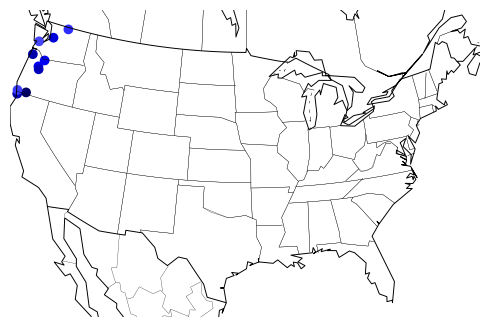

In [20]:
# We can see a clear cluster in the north-west of the US, where the hybrid model performs better than the LSTM model,
# for 100+ return periods. This cluster is clearly located in the area with highest precipitations. Therefore, we
# extract the basins in this area and do the respective analysis.
TR = ["100+"]
model_dif = ["Hybrid", "LSTM"]

# load dataframe with lat/lon information
df_attributes = load_camels_us_attributes(path_data, list(perc_error_peaks.keys())).loc[:, ["gauge_lon", "gauge_lat"]]
df_error = error_per_model_v2[model_dif[0]][TR_interval] - error_per_model_v2[model_dif[1]][TR_interval]
df_error = df_error.join(df_attributes).dropna(subset=["Abs_perc_error"])
df_error = df_error[df_error["Abs_perc_error"] < -0.1]  # select higher errors
df_error = df_error[df_error["gauge_lon"] < -100]  # west of the US

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
m = Basemap(llcrnrlon=-118, llcrnrlat=22, urcrnrlon=-62, urcrnrlat=49, projection="lcc", lat_1=33, lat_2=45, lon_0=-95)
m.drawcoastlines(linewidth=0.7)
m.drawcountries(linewidth=0.7)
m.drawstates(linewidth=0.2)

x, y = m(df_error["gauge_lon"].values, df_error["gauge_lat"].values)  # transform coordinates
scatter = m.scatter(x, y, c=df_error["Abs_perc_error"].values, vmin=-0.3, vmax=0.3, cmap="seismic")
ax.axis(False)
plt.tight_layout()

In [21]:
df_error = df_error.sort_values(by="Abs_perc_error", ascending=False)
df_error["100+"] = discharge_statistics.loc[df_error.index.to_list(), "100"].rename_axis("gauge_id")
df_error

Abs_perc_error  gauge_lon  gauge_lat        100+
gauge_id                                                  
12035000       -0.109403 -123.49488   47.00065  143.847880
14400000       -0.114554 -124.18731   42.12344  168.034490
12447390       -0.122684 -120.14592   48.82292   25.580121
14182500       -0.159651 -122.57897   44.79151  258.072590
14138870       -0.159887 -122.02564   45.48012  179.657446
12147500       -0.181588 -121.78873   47.71232  190.013792
14185900       -0.206747 -122.43591   44.54012  132.678183
11532500       -0.217188 -124.07619   41.79150  128.123663
14301000       -0.222251 -123.75540   45.70400   72.397889
14362250       -0.278494 -123.07532   42.15401   27.362979

Part 12. Saturation Analysis

In [22]:
# Training values
obs_in_training = []
for basin, df in observed_values.items():
    obs_in_training.extend(df["y_obs"][df["y_obs"].index.isin(dates_per_basin_training[basin].values.flatten())].values)

# Highest "n" values in testing -------------------------------------------------------------------------------------
n = 531
obs_peaks_testing = []
obs_peaks_date_testing = []
obs_peaks_associated_basin = []
for basin, value in obs_peaks_per_basin.items():
    obs_peaks_testing.extend(value["value"])
    obs_peaks_date_testing.extend(value["date"])
    obs_peaks_associated_basin.extend([basin] * len(value["value"]))

obs_peaks_testing = np.array(obs_peaks_testing)
obs_peaks_date_testing = np.array(obs_peaks_date_testing)
obs_peaks_associated_basin = np.array(obs_peaks_associated_basin)

indices_highest_n = obs_peaks_testing.argsort()[-n:][::-1]
highest_peaks = np.round(obs_peaks_testing[indices_highest_n], 1)
highest_basins = obs_peaks_associated_basin[indices_highest_n]
print(f"Number of basins in which the peak discharges are located :{len(np.unique(highest_basins))}")

# Associated values for hybrid model
hybrid_peaks_testing = []
for _, value in hybrid_peaks_per_basin.items():
    hybrid_peaks_testing.extend(value["value"])
hybrid_peaks_testing = np.array(hybrid_peaks_testing)
highest_peaks_hybrid = np.round(hybrid_peaks_testing[indices_highest_n], 1)

# Associated values for hybrid model
lstm_peaks_testing = []
for _, value in lstm_peaks_per_basin.items():
    lstm_peaks_testing.extend(value["value"])
lstm_peaks_testing = np.array(lstm_peaks_testing)
highest_peaks_lstm = np.round(lstm_peaks_testing[indices_highest_n], 1)

# Associated values for hybrid model
hbv_peaks_testing = []
for _, value in hbv_peaks_per_basin.items():
    hbv_peaks_testing.extend(value["value"])
hbv_peaks_testing = np.array(hbv_peaks_testing)
highest_peaks_hbv = np.round(hbv_peaks_testing[indices_highest_n], 1)

Number of basins in which the peak discharges are located :171


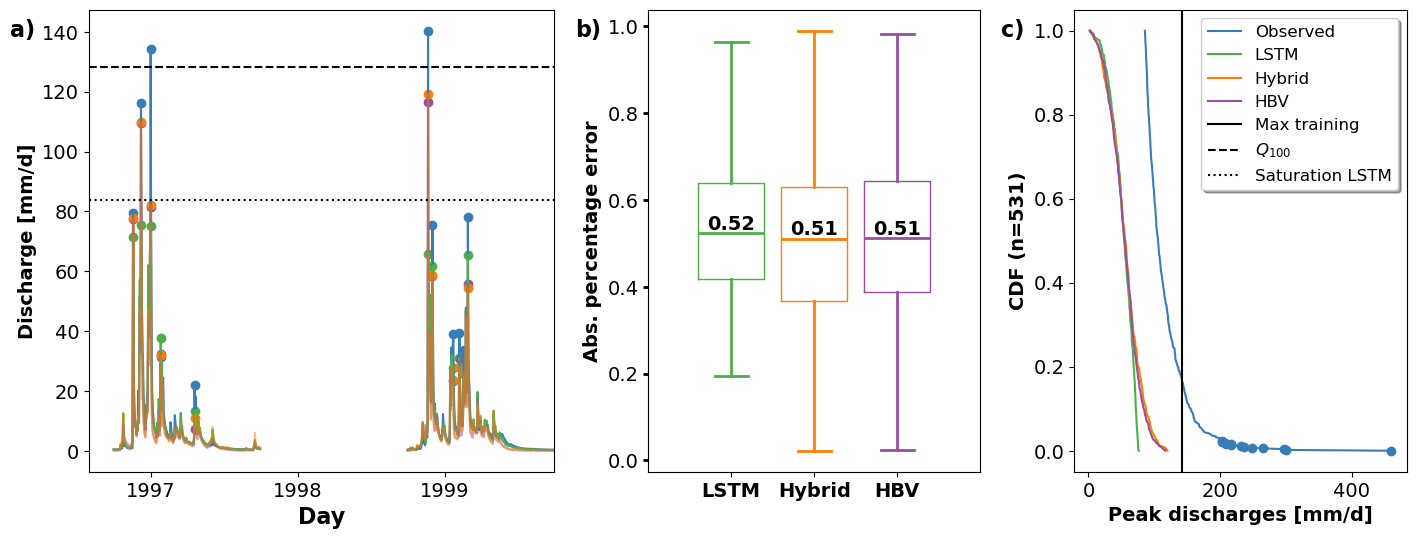

In [23]:
# Correct usage with plt.subplots()
fig, axes = plt.subplots(1, 3, figsize=(17, 6), gridspec_kw={"width_ratios": [1.4, 1, 1]})

# Now you can use the individual axes for plotting
ax0, ax1, ax2 = axes


# First plot ------------------------------------------------------------------------------------------------------
basin_to_analyze = df_error.index[7]
# Observed data
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_obs = hybrid_results[basin_to_analyze]["y_obs"][hybrid_results[basin_to_analyze].index.isin(date_range)]
    ax0.plot(df_obs.index, df_obs, color=color_palette["observed"])
ax0.scatter(
    obs_peaks_per_basin[basin_to_analyze]["date"],
    obs_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    color=color_palette["observed"],
)
# LSTM
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_lstm = lstm_results[basin_to_analyze]["y_sim"][lstm_results[basin_to_analyze].index.isin(date_range)]
    ax0.plot(df_lstm.index, df_lstm, color=color_palette["LSTM"])
ax0.scatter(
    lstm_peaks_per_basin[basin_to_analyze]["date"],
    lstm_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    color=color_palette["LSTM"],
)

# HBV
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_hyb = hbv_results[basin_to_analyze]["y_sim"][hbv_results[basin_to_analyze].index.isin(date_range)]
    ax0.plot(df_hyb.index, df_hyb, alpha=0.5, color=color_palette["HBV"])
ax0.scatter(
    hbv_peaks_per_basin[basin_to_analyze]["date"],
    hbv_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    color=color_palette["HBV"],
)

# Hybrid
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_hyb = hybrid_results[basin_to_analyze]["y_sim"][hybrid_results[basin_to_analyze].index.isin(date_range)]
    ax0.plot(df_hyb.index, df_hyb, alpha=0.5, color=color_palette["Hybrid"])
ax0.scatter(
    hybrid_peaks_per_basin[basin_to_analyze]["date"],
    hybrid_peaks_per_basin[basin_to_analyze]["value"],
    marker="o",
    color=color_palette["Hybrid"],
)
# Add return period limit
ax0.axhline(y=discharge_statistics.loc[basin_to_analyze, "100"], color="black", linestyle="--")
ax0.axhline(
    y=83.9,
    color="black",
    linestyle="dotted",
)

# Format plot
ax0.text(-0.17, 0.98, "a)", transform=ax0.transAxes, fontsize=16, fontweight="bold", verticalalignment="top")
ax0.set_xlabel("Day", fontsize=16, fontweight="bold")
ax0.set_ylabel("Discharge [mm/d]", fontsize=14, fontweight="bold")
ax0.tick_params(axis="both", which="major", labelsize=14)
ax0.set_xlim(datetime.datetime(1996, 8, 1), datetime.datetime(1999, 9, 30))
ax0.xaxis.set_major_locator(mdates.YearLocator(1))  # Change interval to 6 months


# Second plot ------------------------------------------------------------------------------------------------------
abs_peaks_error_lstm = abs(highest_peaks - highest_peaks_lstm) / highest_peaks
abs_peaks_error_hybrid = abs(highest_peaks - highest_peaks_hybrid) / highest_peaks
abs_peaks_error_hbv = abs(highest_peaks - highest_peaks_hbv) / highest_peaks
# Create boxplot for LSTM
ax1.boxplot(
    abs_peaks_error_lstm,
    positions=[0.4],
    showfliers=False,
    widths=0.08,
    patch_artist=False,
    boxprops=dict(color=color_palette["LSTM"]),
    medianprops=dict(color=color_palette["LSTM"], linewidth=2),
    whiskerprops=dict(color=color_palette["LSTM"], linewidth=2),
    capprops=dict(color=color_palette["LSTM"], linewidth=2),
)
# Create boxplot for Hybrid
ax1.boxplot(
    abs_peaks_error_hybrid,
    positions=[0.5],
    showfliers=False,
    widths=0.08,
    patch_artist=False,
    boxprops=dict(color=color_palette["Hybrid"]),
    medianprops=dict(color=color_palette["Hybrid"], linewidth=2),
    whiskerprops=dict(color=color_palette["Hybrid"], linewidth=2),
    capprops=dict(color=color_palette["Hybrid"], linewidth=2),
)

# Create boxplot for HBV
ax1.boxplot(
    abs_peaks_error_hbv,
    positions=[0.6],
    showfliers=False,
    widths=0.08,
    patch_artist=False,
    boxprops=dict(color=color_palette["HBV"]),
    medianprops=dict(color=color_palette["HBV"], linewidth=2),
    whiskerprops=dict(color=color_palette["HBV"], linewidth=2),
    capprops=dict(color=color_palette["HBV"], linewidth=2),
)

ax1.text(-0.22, 0.98, "b)", transform=ax1.transAxes, fontsize=16, fontweight="bold", verticalalignment="top")
ax1.set_xticks([0.4, 0.5, 0.6])
ax1.set_xticklabels(["LSTM", "Hybrid", "HBV"], fontsize=14, fontweight="bold")
ax1.set_ylabel("Abs. percentage error", fontsize=14, fontweight="bold")
ax1.tick_params(axis="y", which="major", labelsize=14, width=2)

ax1.text(
    0.4,
    np.median(abs_peaks_error_lstm),
    f"{np.median(abs_peaks_error_lstm):.2f}",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
)
ax1.text(
    0.5,
    np.median(abs_peaks_error_hybrid),
    f"{np.median(abs_peaks_error_hybrid):.2f}",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
)
ax1.text(
    0.6,
    np.median(abs_peaks_error_hbv),
    f"{np.median(abs_peaks_error_hbv):.2f}",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
)
ax1.set_xlim(left=0.3, right=0.7)


# Third plot ------------------------------------------------------------------------------------------------------
df = pd.DataFrame(
    {"observed": highest_peaks, "lstm": highest_peaks_lstm, "hybrid": highest_peaks_hybrid, "hbv": highest_peaks_hbv}
)
df = df.apply(lambda x: x.sort_values(ascending=False), axis=0, result_type="broadcast")
df["cdf"] = np.arange(len(df)) / (len(df) - 1)


ax2.plot(df["observed"], df["cdf"], label="Observed", color=color_palette["observed"])
ax2.scatter(df["observed"][:13], df["cdf"][:13], color=color_palette["observed"])
ax2.plot(df["lstm"], df["cdf"], label="LSTM", color=color_palette["LSTM"])
ax2.plot(df["hybrid"], df["cdf"], label="Hybrid", color=color_palette["Hybrid"])
ax2.plot(df["hbv"], df["cdf"], label="HBV", color=color_palette["HBV"])
ax2.axvline(x=max(obs_in_training), color="black", linestyle="solid", label="Max training")

# Dummy plots for legend
ax2.plot([], color="black", linestyle="--", label=r"$Q_{100}$")
ax2.plot([], color="black", linestyle="dotted", label="Saturation LSTM")

# Format plot
ax2.text(-0.22, 0.98, "c)", transform=ax2.transAxes, fontsize=16, fontweight="bold", verticalalignment="top")
ax2.set_xlabel("Peak discharges [mm/d]", fontsize=14, fontweight="bold")
ax2.set_ylabel("CDF (n=531)", fontsize=14, fontweight="bold")
ax2.tick_params(axis="both", which="major", labelsize=14)
ax2.legend(loc="upper right", fontsize=12, shadow=True)


plt.subplots_adjust(wspace=0.25)
# plt.savefig("fig05.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

In [24]:
# Highets 10 events: So we can make a more detailed analysis
indices_highest_10 = obs_peaks_testing.argsort()[-10:][::-1]
highest_10_peaks = np.round(obs_peaks_testing[indices_highest_10], 1)
highest_10_peaks_dates = obs_peaks_date_testing[indices_highest_10]
highest_10_peaks_basin = obs_peaks_associated_basin[indices_highest_10]
highest_10_peaks

array([460. , 299.6, 296.6, 264.9, 248.7, 235.5, 231.7, 216.4, 215.8,
       209.4], dtype=float32)

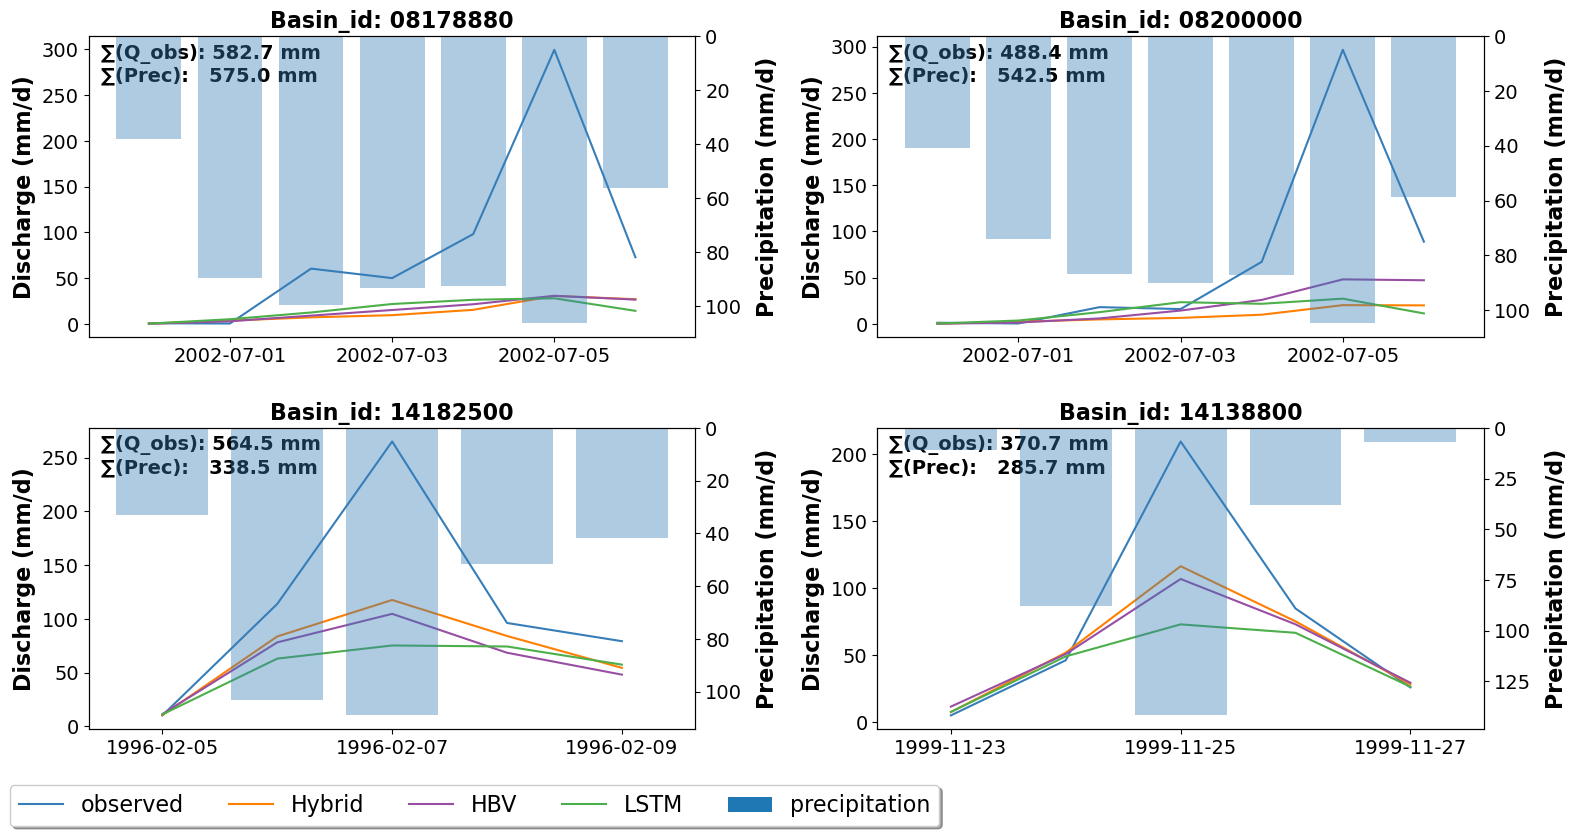

In [25]:
# Dictionary with index of the cases to plot [0-9], and window size for plotting. This was defined manually
extreme_cases = {
    "1": [5, 1],
    "2": [5, 1],
    "3": [2, 2],
    "9": [2, 2],
}

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust space between subplots
axes = axes.flatten()
for i, (case, window) in enumerate(extreme_cases.items()):
    basin_to_analyze = highest_10_peaks_basin[int(case)]
    date_range = pd.date_range(
        start=highest_10_peaks_dates[int(case)] - datetime.timedelta(days=window[0]),
        end=highest_10_peaks_dates[int(case)] + datetime.timedelta(days=window[1]),
    )

    df, _ = load_camels_us_forcings(Path(path_data), basin_to_analyze, "daymet")
    p_series = df["prcp(mm/day)"].loc[date_range]
    acc_p = round(p_series.sum(), 1)

    # Define axis
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # observed discharge
    q_series = hybrid_results[basin_to_analyze].loc[date_range]["y_obs"]
    acc_q = round(q_series.values.sum(), 1)
    ax1.plot(q_series, color=color_palette["observed"])
    # discharge hybrid
    ax1.plot(hybrid_results[basin_to_analyze].loc[date_range]["y_sim"], color=color_palette["Hybrid"])

    # discharge hbv
    ax1.plot(hbv_results[basin_to_analyze].loc[date_range]["y_sim"], color=color_palette["HBV"])

    # discharge lstm
    ax1.plot(lstm_results[basin_to_analyze].loc[date_range]["y_sim"], color=color_palette["LSTM"])

    # precipitation
    ax2.bar(date_range, p_series, color=color_palette["observed"], alpha=0.4)

    # Format plot
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Set interval as needed (e.g., every 2 days)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format the date as desired
    ax1.set_ylabel("Discharge (mm/d)", fontsize=16, fontweight="bold")
    ax1.tick_params(axis="both", which="major", labelsize=14)
    text_str = f"\u2211(Q_obs): {acc_q:0.1f} mm\n\u2211(Prec): {acc_p:>7} mm"
    ax1.text(0.02, 0.85, text_str, transform=ax2.transAxes, fontsize=14, fontweight="bold", color="black")

    ax2.set_ylabel("Precipitation (mm/d)", fontsize=16, fontweight="bold", labelpad=10)
    ax2.tick_params(axis="both", which="major", labelsize=14)
    ax2.invert_yaxis()
    ax1.set_title(f"Basin_id: {basin_to_analyze}", fontsize=16, fontweight="bold")

# Create dummy plots for the legend
ax1.plot([], color=color_palette["observed"], label="observed")
ax1.plot([], color=color_palette["Hybrid"], label="Hybrid")
ax1.plot([], color=color_palette["HBV"], label="HBV")
ax1.plot([], color=color_palette["LSTM"], label="LSTM")
ax1.bar([], [], color=color_palette["observed"], label="precipitation")

# Format plot with a single legend below the subplots
fig.legend(loc="lower left", bbox_to_anchor=(0.075, -0.01), fontsize=16, shadow=True, ncol=5)
# plt.savefig("fig06.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

Part 12. Plot graph of errors divided by return period. Previously it was using the median of the ensemble

In [26]:
# LSTM model -------------------------------------------------------------------------------------------------------
lstm_ensemble_peaks_per_basin = {}
for basin, peak_info in obs_peaks_per_basin.items():
    ensemble_peaks = {}
    for i in range(1, len(path_results_LSTM) + 1):
        max_value = []
        for date in peak_info["date"]:
            window_df = lstm_results[basin][f"y_sim_ens_{i}"].loc[
                date - pd.Timedelta(days=tolerance) : date + pd.Timedelta(days=tolerance)
            ]
            max_value.append(window_df.loc[window_df.idxmax()])

        ensemble_peaks[f"member_{i}"] = max_value

    lstm_ensemble_peaks_per_basin[basin] = ensemble_peaks

In [27]:
hybrid_results_seeds = {}
for i, ensemble_member in enumerate(path_results_hybrid):
    with open(ensemble_member + "/test/model_epoch020/test_results.p", "rb") as f:
        info_hybrid = pickle.load(f)
        for basin in info_hybrid.keys():
            y_sim = info_hybrid[basin]["1D"]["xr"]["QObs(mm/d)_sim"].to_pandas().iloc[0].values
            if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
                y_obs = info_hybrid[basin]["1D"]["xr"]["QObs(mm/d)_obs"].to_pandas().iloc[0].values
                hybrid_results_seeds[basin] = pd.DataFrame(
                    data={
                        "y_obs": y_obs[full_date_range.isin(dates_per_basin_testing[basin]["date"])],
                        f"y_sim_ens_{i+1}": y_sim[full_date_range.isin(dates_per_basin_testing[basin]["date"])],
                    },
                    index=full_date_range[full_date_range.isin(dates_per_basin_testing[basin]["date"])],
                )
            else:  # For subsequent ensemble members, add y_sim as a new column
                hybrid_results_seeds[basin][f"y_sim_ens_{i+1}"] = y_sim[
                    full_date_range.isin(dates_per_basin_testing[basin]["date"])
                ]


hybrid_ensemble_peaks_per_basin = {}
for basin, peak_info in obs_peaks_per_basin.items():
    ensemble_peaks = {}
    for i in range(1, len(path_results_hybrid) + 1):
        max_value = []
        for date in peak_info["date"]:
            window_df = hybrid_results_seeds[basin][f"y_sim_ens_{i}"].loc[
                date - pd.Timedelta(days=tolerance) : date + pd.Timedelta(days=tolerance)
            ]
            max_value.append(window_df.loc[window_df.idxmax()])

        ensemble_peaks[f"member_{i}"] = max_value

    hybrid_ensemble_peaks_per_basin[basin] = ensemble_peaks

In [28]:
# Calculate peak errors for all the models
perc_error_peaks_ensemble = {}
for basin, peak_info in obs_peaks_per_basin.items():
    errors_per_model_ensemble = {}
    obs_peaks = peak_info["value"]
    # Hybrid model ----------------------------------------------------------------------------------------------------
    for i in range(1, len(path_results_hybrid) + 1):
        hybrid_peaks = np.array(hybrid_ensemble_peaks_per_basin[basin][f"member_{i}"])
        errors_per_model_ensemble[f"Hybrid_{i}"] = np.abs(obs_peaks - hybrid_peaks) / obs_peaks
    # HBV model -------------------------------------------------------------------------------------------------------
    hbv_peaks = np.array(hbv_peaks_per_basin[basin]["value"])
    errors_per_model_ensemble["HBV"] = np.abs(obs_peaks - hbv_peaks) / obs_peaks
    # LSTM model ------------------------------------------------------------------------------------------------------
    for i in range(1, len(path_results_LSTM) + 1):
        lstm_peaks = np.array(lstm_ensemble_peaks_per_basin[basin][f"member_{i}"])
        errors_per_model_ensemble[f"LSTM_{i}"] = np.abs(obs_peaks - lstm_peaks) / obs_peaks

    perc_error_peaks_ensemble[basin] = errors_per_model_ensemble

In [29]:
# Models
model_name = ["HBV"]
for i in range(1, len(path_results_hybrid) + 1):
    model_name.append(f"Hybrid_{i}")
for i in range(1, len(path_results_LSTM) + 1):
    model_name.append(f"LSTM_{i}")

# Intialize structure to save error per model and per return period
error_per_model_ensemble = {model: {TR: [] for TR in TR_range} for model in model_name}

# Process and store the error per model per return period
for basin, peak_error_per_model in perc_error_peaks_ensemble.items():
    for model in peak_error_per_model.keys():
        for i, TR in enumerate(TR_range):
            error_per_model_ensemble[model][TR].extend(peak_error_per_model[model][classified_peaks[basin] == i + 1])

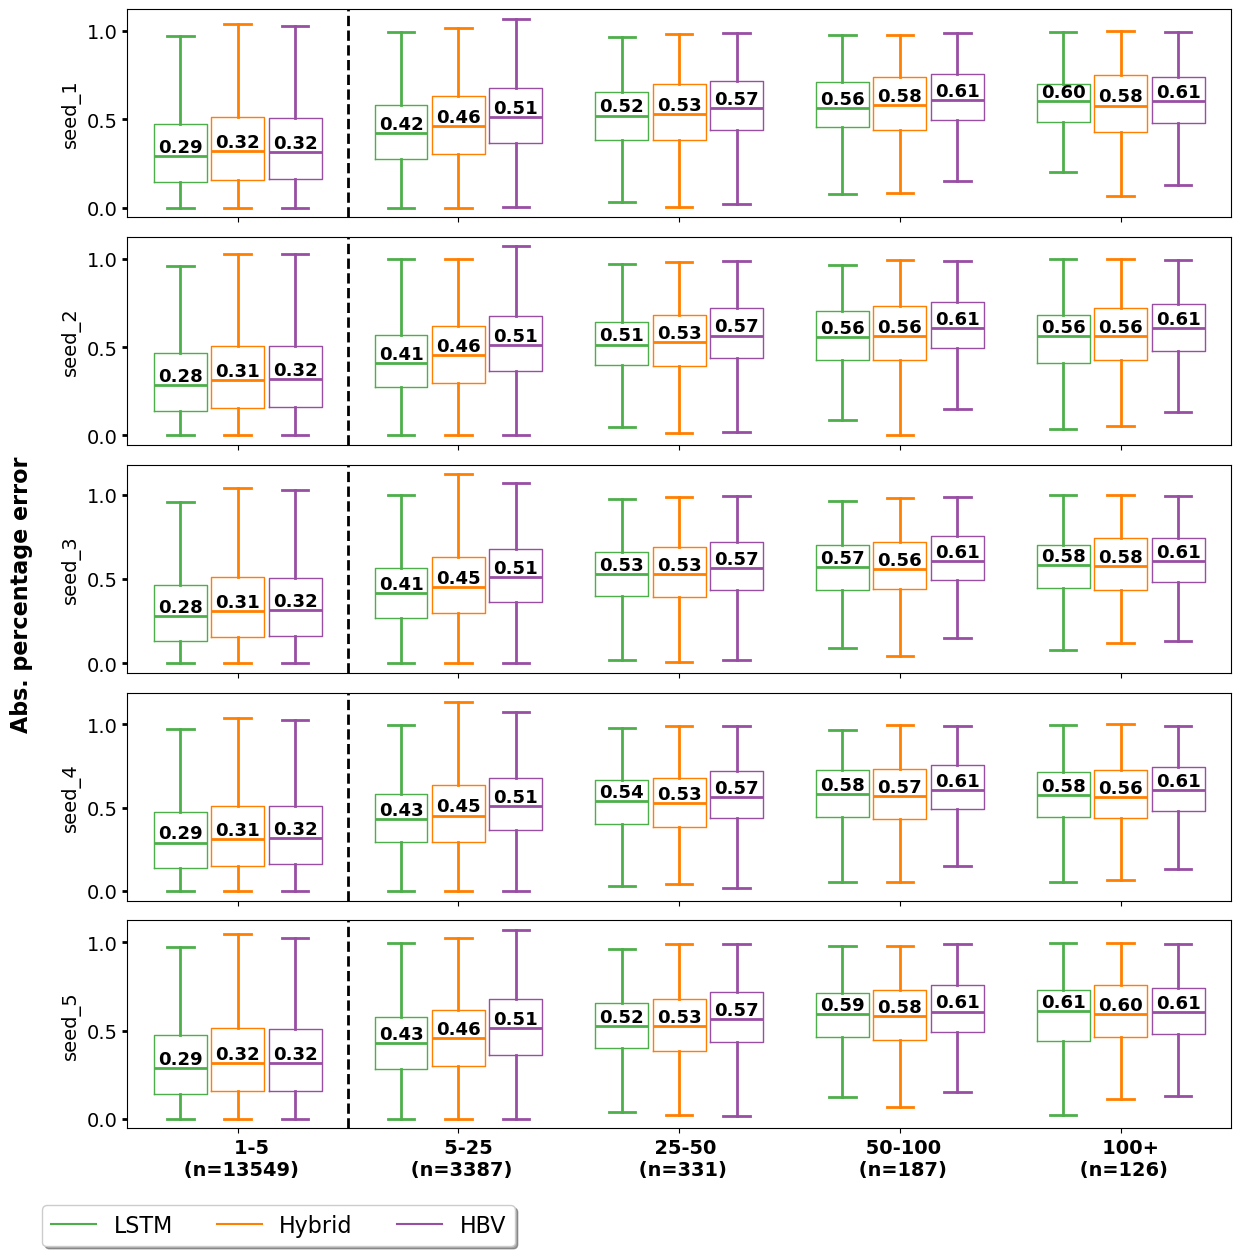

In [30]:
# Assuming ri_list is a dictionary containing data for different models
step = 0.5
bin_names = [f"{TR_range[i]:>7}\n (n={len(value)})" for i, (_, value) in enumerate(error_per_model_ensemble["Hybrid_1"].items())]
x = np.arange(0, len(list(bin_names)) * step, step)  # the label locations
width = 0.13  # Width of each boxplot

fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)  # 2 rows, 2 columns
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i in range(len(path_results_LSTM)):
    # Iterate through each bin_name and create boxplots for each model
    for j, TR in enumerate(TR_range):
        # LSTM boxplots
        errors_lstm = error_per_model_ensemble[f"LSTM_{i+1}"][TR]
        axs[i].boxplot(
            errors_lstm,
            positions=[x[j] - width],
            showfliers=False,
            widths=0.12,
            patch_artist=False,
            boxprops=dict(color=color_palette["LSTM"]),
            medianprops=dict(color=color_palette["LSTM"], linewidth=2),
            whiskerprops=dict(color=color_palette["LSTM"], linewidth=2),
            capprops=dict(color=color_palette["LSTM"], linewidth=2),
        )

        axs[i].text(
            x[j] - width,
            np.median(errors_lstm),
            f"{np.median(errors_lstm):.2f}",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontsize=13,
            fontweight="bold",
            color="black",
        )

        # Hybrid boxplots
        errors_hybrid = error_per_model_ensemble[f"Hybrid_{i+1}"][TR]
        axs[i].boxplot(
            errors_hybrid,
            positions=[x[j]],
            showfliers=False,
            widths=0.12,
            patch_artist=False,
            boxprops=dict(color=color_palette["Hybrid"]),
            medianprops=dict(color=color_palette["Hybrid"], linewidth=2),
            whiskerprops=dict(color=color_palette["Hybrid"], linewidth=2),
            capprops=dict(color=color_palette["Hybrid"], linewidth=2),
        )

        axs[i].text(
            x[j],
            np.median(errors_hybrid),
            f"{np.median(errors_hybrid):.2f}",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontsize=13,
            fontweight="bold",
            color="black",
        )

        # HBV boxplots
        errors_hbv = error_per_model_ensemble["HBV"][TR]
        axs[i].boxplot(
            errors_hbv,
            positions=[x[j] + width],
            showfliers=False,
            widths=0.12,
            patch_artist=False,
            boxprops=dict(color=color_palette["HBV"]),
            medianprops=dict(color=color_palette["HBV"], linewidth=2),
            whiskerprops=dict(color=color_palette["HBV"], linewidth=2),
            capprops=dict(color=color_palette["HBV"], linewidth=2),
        )

        axs[i].text(
            x[j] + width,
            np.median(errors_hbv),
            f"{np.median(errors_hbv):.2f}",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontsize=13,
            fontweight="bold",
            color="black",
        )

    # Line dividing interpolation - extrapolation errors
    axs[i].axvline(x=0.25, color="black", linestyle="--", linewidth=2)

    # Add labels, titles, legends, etc. as needed
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(bin_names, fontsize=14, fontweight="bold")
    axs[i].set_xlim(left=x[0] - step / 2, right=x[-1] + step / 2)
    axs[i].set_yticks([0, 0.5, 1])
    axs[i].set_ylabel(f"seed_{i+1}", fontsize=14)
    axs[i].tick_params(axis="y", labelsize=14, width=2)

# Set y-label for the middle row on the left side
fig.text(-0.03, 0.5, "Abs. percentage error", va="center", rotation="vertical", fontsize=16, fontweight="bold")
# Create a single legend at the bottom
# Dummy plots for the legend
handles = [
    plt.Line2D([], [], color=color_palette["LSTM"], label="LSTM"),
    plt.Line2D([], [], color=color_palette["Hybrid"], label="Hybrid"),
    plt.Line2D([], [], color=color_palette["HBV"], label="HBV"),
]

fig.legend(handles=handles, bbox_to_anchor=(0.4, 0), fontsize=16, shadow=True, ncol=3)

plt.tight_layout()
#plt.savefig("figB1.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

Part 13. Theoretical prediction limit LSTM

In [31]:
# Read trained lstm model
for i, ensemble_member in enumerate(path_results_LSTM):
    path_config = Path(ensemble_member + "/config.yml")
    path_model = ensemble_member + "/model_epoch020.pt"
    path_scaler = Path(ensemble_member + "/train_data/train_data_scaler.yml")

    # Read scaler
    scaler_file = Path("lstm_extrapolation_seed_100_0807_151158/train_data/train_data_scaler.yml")
    with scaler_file.open("r") as fp:
        yaml = YAML(typ="safe")
        scaler_dump = yaml.load(fp)

    scaler = {}
    for key, value in scaler_dump.items():
        if key in ["attribute_means", "attribute_stds", "camels_attr_means", "camels_attr_stds"]:
            scaler[key] = pd.Series(value)
        elif key in ["xarray_feature_scale", "xarray_feature_center"]:
            scaler[key] = xarray.Dataset.from_dict(value).astype(np.float32)

    Q_mean = scaler["xarray_feature_center"]["QObs(mm/d)"].item()
    Q_std = scaler["xarray_feature_scale"]["QObs(mm/d)"].item()

    # Read model
    lstm_model = CudaLSTM(Config(path_config))
    lstm_model.load_state_dict(torch.load(path_model, map_location="cpu"))

    # Calculate theoretical prediction limit
    linear_layer = lstm_model.head.net[0]
    # Convert weights and bias to numpy arrays if needed
    theoretical_limit = (
        np.sum(np.abs(linear_layer.weight.data.numpy())) + linear_layer.bias.data.numpy()
    ) * Q_std + Q_mean

    # Maximum value predicted during testing
    lstm_peaks_testing = []
    for _, value in lstm_ensemble_peaks_per_basin.items():
        lstm_peaks_testing.extend(value[f"member_{i+1}"])

    print(
        f'Ensemble member {i+1}: Maximum theoretical limit: {"%.1f "% theoretical_limit[0]:>3}mm | Highest simulated peak: {"%.1f "% max(lstm_peaks_testing):>3}mm'
    )

Ensemble member 1: Maximum theoretical limit: 83.9 mm | Highest simulated peak: 78.9 mm
Ensemble member 2: Maximum theoretical limit: 81.3 mm | Highest simulated peak: 76.5 mm
Ensemble member 3: Maximum theoretical limit: 81.9 mm | Highest simulated peak: 76.9 mm
Ensemble member 4: Maximum theoretical limit: 82.1 mm | Highest simulated peak: 76.5 mm
Ensemble member 5: Maximum theoretical limit: 81.4 mm | Highest simulated peak: 76.0 mm


Part 14. Parameter variation over time for hybrid model

In [32]:
# print(dates_per_basin_testing["01022500"]["date"].dt.year.unique())
# ------------
selected_dates_basin = []
selected_indices_basin = []

# Longest continuos period for basin 14400000
start_date = datetime.datetime(1996, 10, 1)
end_date = datetime.datetime(1999, 9, 30)
selected_dates_basin.append(full_date_range[(full_date_range >= start_date) & (full_date_range <= end_date)])
# Get the positions of these dates within the full_range index
selected_indices_basin.append(full_date_range.get_indexer(selected_dates_basin[0]))

# Longest continuos period for basin 11532500
start_date = datetime.datetime(1996, 10, 1)
end_date = datetime.datetime(1999, 9, 30)
selected_dates_basin.append(full_date_range[(full_date_range >= start_date) & (full_date_range <= end_date)])
# Get the positions of these dates within the full_range index
selected_indices_basin.append(full_date_range.get_indexer(selected_dates_basin[1]))

# Longest continuos period for basin 01022500
start_date = datetime.datetime(2004, 10, 1)
end_date = datetime.datetime(2007, 9, 30)
selected_dates_basin.append(full_date_range[(full_date_range >= start_date) & (full_date_range <= end_date)])
# Get the positions of these dates within the full_range index
selected_indices_basin.append(full_date_range.get_indexer(selected_dates_basin[2]))

In [33]:
# Read information produced by hybrid (including dynamic parameters) and store it in dictionary of dataframes ----------
with open(path_results_hybrid[0] + "/test/model_epoch020/test_results.p", "rb") as f:
    discharge_information = pickle.load(f)

with open(path_results_hybrid[0] + "/test/model_epoch020/test_all_output.p", "rb") as f:
    output_information = pickle.load(f)

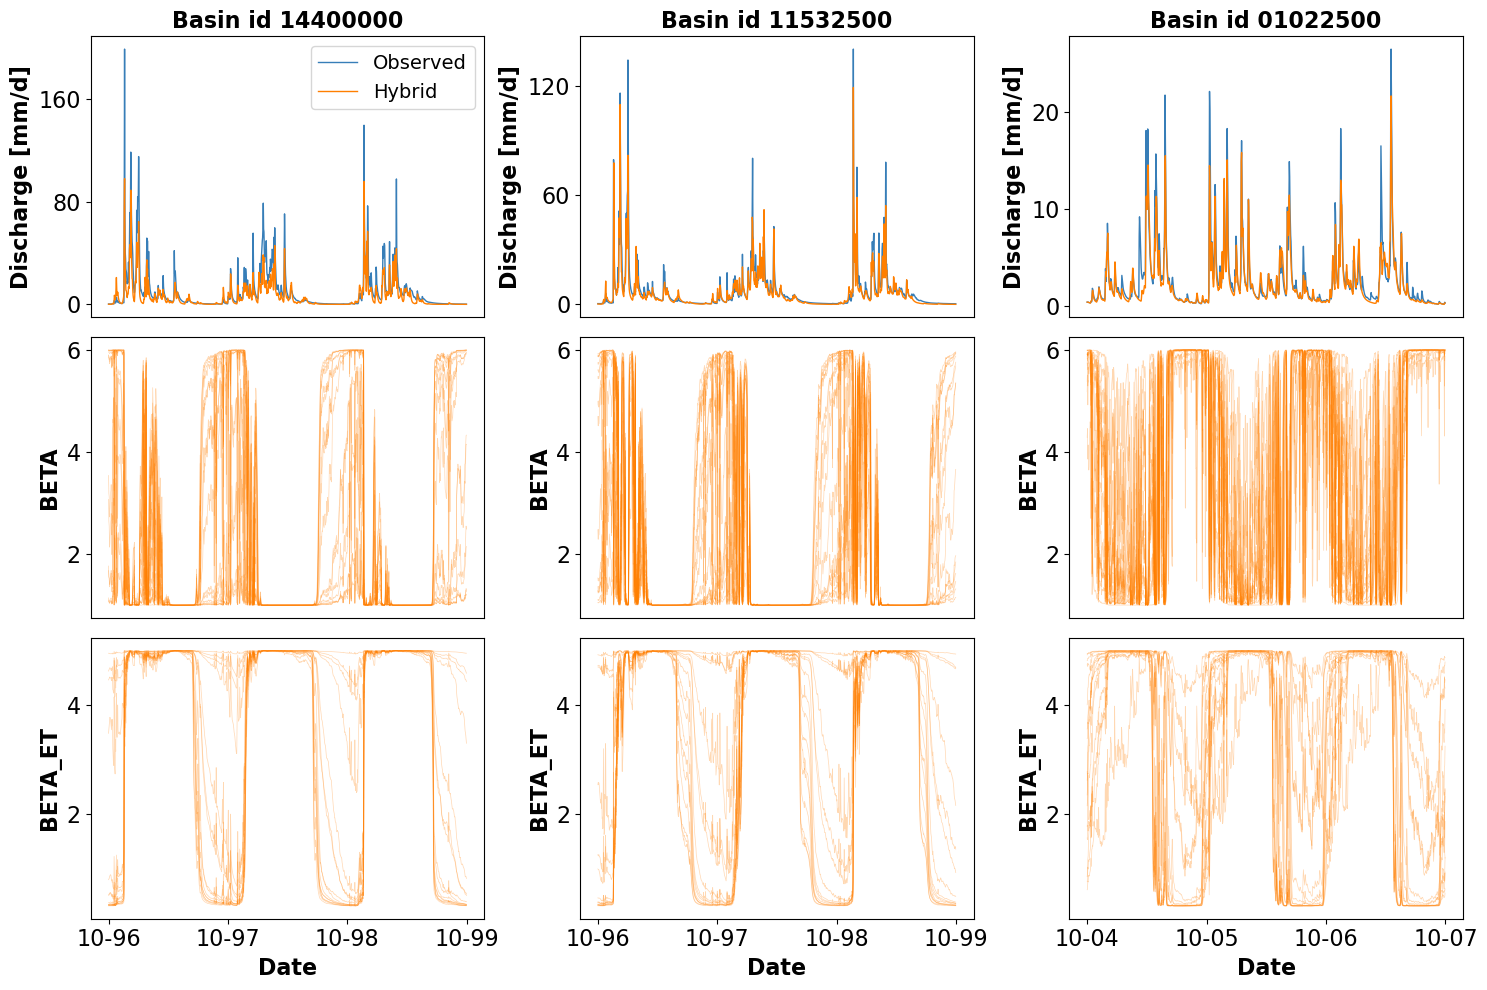

In [34]:
# Plot to see how the paramters vary in time. There are some axis scales that are hard coded! Change if necessary
basin_to_analyze = ["14400000", "11532500", "01022500"]  #  14400000 01022500
parameters_to_plot = {"BETA": 0, "BETA_ET": 12}  # name, id

# Creating the figure and subplots
fig, axs = plt.subplots(len(parameters_to_plot) + 1, len(basin_to_analyze), figsize=(15, 10))

for i, basin in enumerate(basin_to_analyze):
    # First subplot is always the discharge
    obs = (
        discharge_information[basin_to_analyze[i]]["1D"]["xr"]["QObs(mm/d)_obs"]
        .to_pandas()
        .iloc[0]
        .values[selected_indices_basin[i]]
    )
    sim = (
        discharge_information[basin_to_analyze[i]]["1D"]["xr"]["QObs(mm/d)_sim"]
        .to_pandas()
        .iloc[0]
        .values[selected_indices_basin[i]]
    )
    axs[0, i].plot(selected_dates_basin[i], obs, label="Observed", color=color_palette["observed"], linewidth=1.0)
    axs[0, i].plot(selected_dates_basin[i], sim, label="Hybrid", color=color_palette["Hybrid"], linewidth=1.0)
    axs[0, i].set_title("Basin id " + basin_to_analyze[i], fontsize=16, fontweight="bold")
    axs[0, i].set_ylabel("Discharge [mm/d]", fontsize=16, fontweight="bold")
    axs[0, i].yaxis.set_major_locator(MaxNLocator(nbins=3))
    axs[0, i].tick_params(axis="both", which="major", labelsize=16)  # Set font size for tick labels
    if i == 0:
        axs[0, i].legend(loc="upper right", fontsize=14)

    # Parameter plots
    for j, (parameter_name, parameter_id) in enumerate(parameters_to_plot.items()):
        param_values = output_information[basin_to_analyze[i]]["parameters"][selected_indices_basin[i], :, parameter_id]
        # Plot the line for the model ensemble
        for k in range(param_values.shape[1]):
            axs[j + 1, i].plot(
                selected_dates_basin[i], param_values[:, k], color=color_palette["Hybrid"], linewidth=0.5, alpha=0.3
            )

        axs[j + 1, i].yaxis.set_major_locator(MaxNLocator(nbins=3))
        axs[j + 1, i].tick_params(axis="both", which="major", labelsize=16)
        axs[j + 1, i].set_ylabel(parameter_name, fontsize=16, fontweight="bold")

    if j == len(parameters_to_plot) - 1:
        axs[j + 1, i].set_xlabel("Date", fontsize=16, fontweight="bold")
        axs[j + 1, i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=10))
        axs[j + 1, i].xaxis.set_major_formatter(mdates.DateFormatter("%m-%y"))
        axs[j + 1, i].tick_params(axis="both", which="major", labelsize=16)


# Remove x-axis labels for first n-1 rows
for i in range(len(parameters_to_plot)):
    for j in range(len(basin_to_analyze)):
        axs[i, j].xaxis.set_visible(False)

# Adjusting the layout for better spacing
plt.tight_layout()

# Displaying the graph
# plt.savefig('figD1.png', bbox_inches='tight', pad_inches=0.05, dpi=300)
plt.show()